# Fluid Dynamics: finding the optimal Tesla Valve Design

Team 9: Kyrian Puttileihalat, Liam Gatersleben, Pieter Duindam, Sebas van Waard



In [ ]:
# python -m ipykernel install \
#  --user \
#  --name pylbm-env \  # CHANGE THIS TO YOUR VENV FOLDER NAME
# --display-name "Python (pylbm-env)"

## 1. Introduction

Fluid control is a central problem in fluid dynamics, particularly in systems where passive, robust flow regulation is desired. One notable example is the *Tesla valve*, a valve geometry designed to strongly resist flow in one direction while allowing relatively unobstructed flow in the opposite direction, without the use of moving parts.

The effectiveness of a Tesla valve depends heavily on its geometric design. Parameters such as valve length, channel diameter, loop spacing, and loop overlap influence how momentum is redirected and dissipated within the valve. Additionally, fluid properties such as flow speed and viscosity play a crucial role in determining overall performance.

In this project, we investigate how variations in Tesla valve geometry affect its ability to restrict reverse flow under different fluid conditions. Using numerical fluid simulations, we aim to identify optimal valve designs for a range of flow speeds and viscosities. A secondary objective is to determine whether loop spacing remains influential in cases where valve loops do not overlap.

The simulations are performed using the Lattice Boltzmann Method, which is well suited for modeling complex boundary geometries and flow behavior in two dimensions.


### Experiment 1

Because the Lattice Boltzmann Method is quite computationally expensive, it is important to minimize the computational power needed. Because of this, the timepoint at which we measure the effectiveness of our valve should be as low as possible.

For the first experiment this is timepoint is what we will look for.

All experiments below will be done for an LBM with parameters:
- la (scheme velocity) = 1.02
- input_vel (input velocity) = 0.015
- Re (Reynolds number) = 20

To find the optimal timepoint we've used a standard Tesla Valve with:
- r = 0.1
- dy (length of loop) = 0.35
- width (diameter of valve) = 0.07

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pylbm

from pathlib import Path

from src.class_test import Simulation
from src.valve_generator import generate_valve

import warnings
import logging

warnings.filterwarnings("ignore", module="pylbm")
warnings.filterwarnings("ignore", message=".*FigureCanvasAgg.*")
logging.getLogger("pylbm").setLevel(logging.ERROR)


In [2]:
# set simulation paramters
simulaton_params = {
    "png_path": "data/valve.png",
    "visualization_by": "pressure_field",
    "la": 1.02,
    "input_vel": 0.015,
    "Re": 20
    }

In [3]:
def diodicity_over_time(max_t = 10000, start_t = 0, step = 50):
    max_timepoint = max_t
    timepoint = start_t
    timestep = step

    # Create simulations
    sim_fwd = Simulation(flip_x=True, Tf = max_timepoint, **simulaton_params)
    sim_rev = Simulation(flip_x=False, Tf= max_timepoint, **simulaton_params)

    sim_fwd.build_simulation()
    sim_rev.build_simulation()

    diodicities = []
    timepoints = []

    while timepoint < max_timepoint:
        timepoint += timestep
        for _ in range(timestep):
            sim_fwd.sol.one_time_step()
            sim_rev.sol.one_time_step()
        
        fwd_fr = sim_fwd.flow_resistance()
        rev_fr = sim_rev.flow_resistance()

        diodicity = rev_fr / fwd_fr
        print(f"Diodicity at t = {timepoint}: {diodicity}", end="\r")

        diodicities.append(diodicity)
        timepoints.append(timepoint)
    
    return diodicities, timepoints

In [ ]:
widths = [0.07, 0.085]
radii = [0.09, 0.14]
dys = [0.30, 0.50]

diodicities = []
timepoints = []

results_dir = Path("results")
results_dir.mkdir(exist_ok=True)

master_csv = results_dir / "diodicity_sweep_all.csv"
if master_csv.exists():
    master_csv.unlink()

write_master_header = True

# -------------------------
# Parameter sweep (fail-safe)
# -------------------------
for width in widths:
    for radius in radii:
        for dy in dys:

            # Per-experiment CSV
            exp_csv = results_dir / f"separate_sweep/diodicity_w{width}_r{radius}_dy{dy}.csv"
            if exp_csv.exists():
                exp_csv.unlink()

            write_exp_header = True

            try:
                generate_valve(width, 2, dy, radius, 1)
                diods, times = diodicity_over_time()

            except Exception:
                # If the whole experiment fails
                diods = []
                times = []

            # Keep for plotting (even if empty)
            diodicities.append(diods)
            timepoints.append(times)

            # -------------------------
            # Write results (if any)
            # -------------------------
            if len(times) > 0:
                df = pd.DataFrame(
                    {
                        "width": width,
                        "radius": radius,
                        "dy": dy,
                        "timepoint": times,
                        "diodicity": diods,
                    }
                )
            else:
                # Ensure file exists even on failure
                df = pd.DataFrame(
                    {
                        "width": [width],
                        "radius": [radius],
                        "dy": [dy],
                        "timepoint": [np.nan],
                        "diodicity": [np.nan],
                    }
                )

            # Per-experiment CSV
            df.to_csv(
                exp_csv,
                mode="a",
                header=write_exp_header,
                index=False,
            )
            write_exp_header = False

            # Master CSV
            df.to_csv(
                master_csv,
                mode="a",
                header=write_master_header,
                index=False,
            )
            write_master_header = False

# -------------------------
# Plot
# -------------------------
n = len(diodicities)
cmap = plt.get_cmap("viridis")

for i, (x, y) in enumerate(zip(timepoints, diodicities)):
    if len(x) == 0:
        continue
    color = cmap(i / n)
    plt.plot(x, y, color=color, label=f"Exp {i+1}")

plt.xlabel("time")
plt.ylabel("diodicity")
plt.title("Diodicities over time for 8 arbitrary valves")
plt.ylim((0, 5))
plt.legend()
plt.show()

From these results we find that at about t = 4000 the diodacity finds its equilibrium for all tested valves. Therefore we have set our measurement time at t = 4000, resulting in the following parameters:
- la (scheme velocity) = 1.02
- input_vel (input velocity) = 0.015
- Re (Reynolds number) = 20
- Tf (max t) = 4000

In [4]:
sim_params = {
    "png_path": "data/valve.png",
    "visualization_by": "pressure_field",
    "la": 1.02,
    "input_vel": 0.015,
    "Re": 20,
    "Tf": 4000
    }

### Experiment 2

Now that we know at which timpoint we can consistently measure the diodicity of the valve, we can continue our search to find the optimal configuration of the tesla valve.

To start of we will look for the optimal valve diameter, while keeping the parameters of the unit valve the same.

In [ ]:
width = np.linspace(0.03, 0.1, 100)
D = []

csv_path = Path("results/diodicity_vs_width.csv")

# -------------------------
# Clear CSV before run
# -------------------------
if csv_path.exists():
    csv_path.unlink()

write_header = True

# -------------------------
# Parameter sweep (fail-safe)
# -------------------------
for w in width:
    try:
        generate_valve(w, 2, 0.35, 0.1, 1)

        sim_rev = Simulation(flip_x=False, **sim_params)
        sim_for = Simulation(flip_x=True, **sim_params)

        sim_for.run()
        sim_rev.run()

        diodicity = sim_rev.flow_resistance() / sim_for.flow_resistance()

    except Exception:
        diodicity = np.nan

    D.append(diodicity)

    # Immediate CSV write
    df = pd.DataFrame(
        {
            "width": [w],
            "diodicity": [diodicity],
        }
    )

    df.to_csv(
        csv_path,
        mode="a",
        header=write_header,
        index=False,
    )
    write_header = False

# -------------------------
# Plot
# -------------------------
plt.plot(width, D)
plt.xlabel("Width")
plt.ylabel("Diodicity")
plt.title("Diodicity vs Width")
plt.show()


## Experiment 3

radius

In [ ]:
radius = np.linspace(0.05, 0.17, 100)
D = []

csv_path = Path("results/diodicity_vs_radius.csv")

# -------------------------
# Clear CSV before run
# -------------------------
if csv_path.exists():
    csv_path.unlink()

write_header = True

# -------------------------
# Parameter sweep (fail-safe)
# -------------------------
for r in radius:
    try:
        generate_valve(0.04, 2, 0.35, r, 1)

        sim_rev = Simulation(flip_x=False, **sim_params)
        sim_for = Simulation(flip_x=True, **sim_params)

        sim_for.run()
        sim_rev.run()

        diodicity = sim_rev.flow_resistance() / sim_for.flow_resistance()

    except Exception:
        diodicity = np.nan

    D.append(diodicity)

    # Immediate CSV write
    df = pd.DataFrame(
        {
            "radius": [r],
            "diodicity": [diodicity],
        }
    )

    df.to_csv(
        csv_path,
        mode="a",
        header=write_header,
        index=False,
    )
    write_header = False

# -------------------------
# Plot
# -------------------------
plt.plot(radius, D)
plt.xlabel("Radius")
plt.ylabel("Diodicity")
plt.title("Diodicity vs Radius")
plt.show()

## Experiment 4

dy

In [ ]:
dy = np.linspace(0.25, 0.6, 100)
D = []

csv_path = Path("results/diodicity_vs_dy.csv")

if csv_path.exists():
    csv_path.unlink()

write_header = True

# -------------------------
# Parameter sweep (fail-safe)
# -------------------------
for y in dy:
    try:
        generate_valve(0.04, 2, y, 0.1, 1)

        sim_rev = Simulation(flip_x=False, **sim_params)
        sim_for = Simulation(flip_x=True, **sim_params)

        sim_for.run()
        sim_rev.run()

        diodicity = sim_rev.flow_resistance() / sim_for.flow_resistance()

    except Exception:
        diodicity = np.nan

    # Keep alignment for plotting
    D.append(diodicity)

    # Immediate CSV write
    df = pd.DataFrame(
        {
            "dy": [y],
            "diodicity": [diodicity],
        }
    )

    df.to_csv(
        csv_path,
        mode="a",
        header=write_header,
        index=False,
    )
    write_header = False

# -------------------------
# Plot
# -------------------------
plt.plot(dy, D)
plt.xlabel("dy")
plt.ylabel("Diodicity")
plt.title("Diodicity vs dy")
plt.show()


## Experiment 5

plane of radius and width

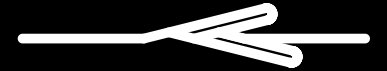

r=0.0500, dy=0.2500, Di=1.2020


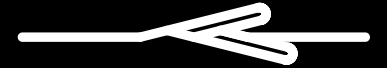

r=0.0552, dy=0.2500, Di=1.2366


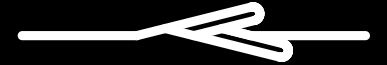

r=0.0604, dy=0.2500, Di=1.2538


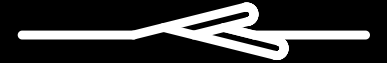

r=0.0657, dy=0.2500, Di=1.2692


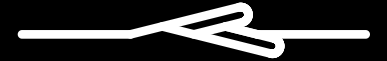

r=0.0709, dy=0.2500, Di=1.2469


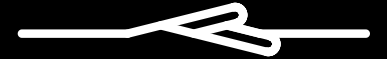

r=0.0761, dy=0.2500, Di=1.2148


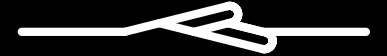

r=0.0813, dy=0.2500, Di=1.2093


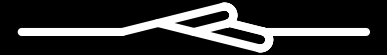

r=0.0865, dy=0.2500, Di=1.2143


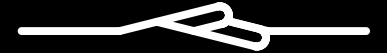

r=0.0917, dy=0.2500, Di=1.2327


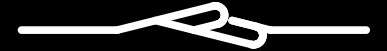

r=0.0970, dy=0.2500, Di=1.0498


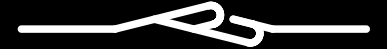

r=0.1022, dy=0.2500, Di=1.0307


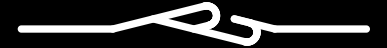

r=0.1074, dy=0.2500, Di=1.0271


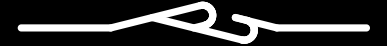

r=0.1126, dy=0.2500, Di=0.9996


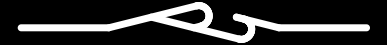

r=0.1178, dy=0.2500, Di=1.0251


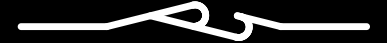

r=0.1230, dy=0.2500, Di=0.9718


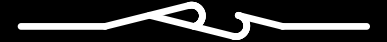

r=0.1283, dy=0.2500, Di=0.9453


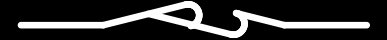

r=0.1335, dy=0.2500, Di=0.9833


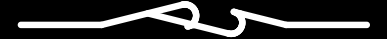

r=0.1387, dy=0.2500, Di=0.9545


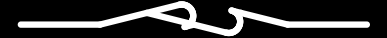

r=0.1439, dy=0.2500, Di=0.9567


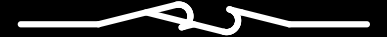

r=0.1491, dy=0.2500, Di=0.9546


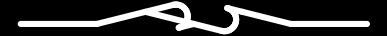

r=0.1543, dy=0.2500, Di=0.9469


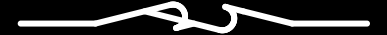

r=0.1596, dy=0.2500, Di=1.0193


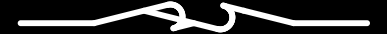

r=0.1648, dy=0.2500, Di=0.9930


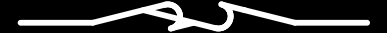

r=0.1700, dy=0.2500, Di=0.9528


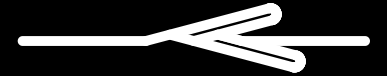

r=0.0500, dy=0.2652, Di=1.2417


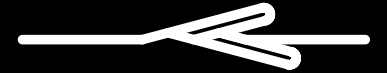

r=0.0552, dy=0.2652, Di=1.2393


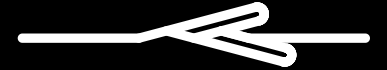

r=0.0604, dy=0.2652, Di=1.2254


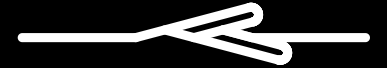

r=0.0657, dy=0.2652, Di=1.2652


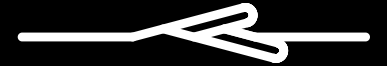

r=0.0709, dy=0.2652, Di=1.2566


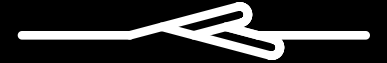

r=0.0761, dy=0.2652, Di=1.2385


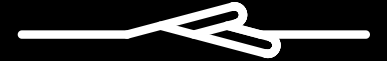

r=0.0813, dy=0.2652, Di=1.2219


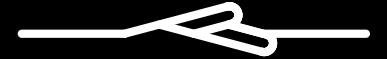

r=0.0865, dy=0.2652, Di=1.2273


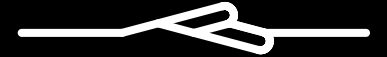

r=0.0917, dy=0.2652, Di=1.2706


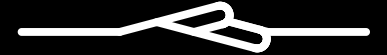

r=0.0970, dy=0.2652, Di=1.2322


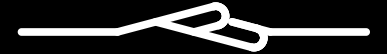

r=0.1022, dy=0.2652, Di=1.1591


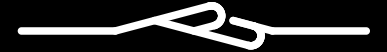

r=0.1074, dy=0.2652, Di=1.0150


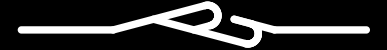

r=0.1126, dy=0.2652, Di=1.0247


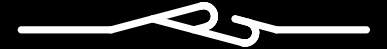

r=0.1178, dy=0.2652, Di=1.0480


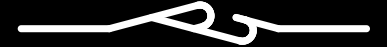

r=0.1230, dy=0.2652, Di=0.9973


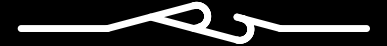

r=0.1283, dy=0.2652, Di=0.9994


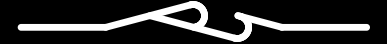

r=0.1335, dy=0.2652, Di=0.9747


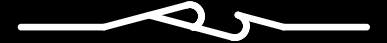

r=0.1387, dy=0.2652, Di=0.9906


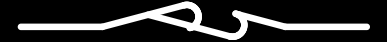

r=0.1439, dy=0.2652, Di=0.9983


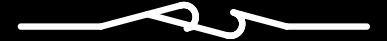

r=0.1491, dy=0.2652, Di=0.9729


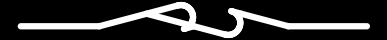

r=0.1543, dy=0.2652, Di=0.9620


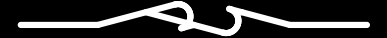

r=0.1596, dy=0.2652, Di=0.9867


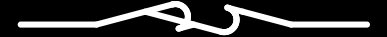

r=0.1648, dy=0.2652, Di=0.9573


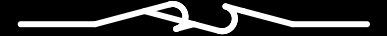

r=0.1700, dy=0.2652, Di=0.9590


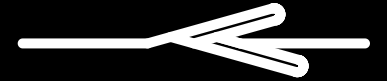

r=0.0500, dy=0.2804, Di=1.2324


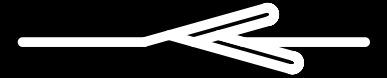

r=0.0552, dy=0.2804, Di=1.2521


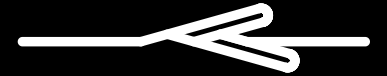

r=0.0604, dy=0.2804, Di=1.2510


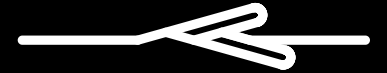

r=0.0657, dy=0.2804, Di=1.2661


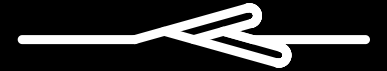

r=0.0709, dy=0.2804, Di=1.2671


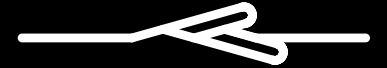

r=0.0761, dy=0.2804, Di=1.2787


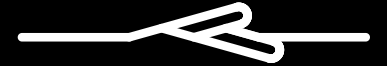

r=0.0813, dy=0.2804, Di=1.2367


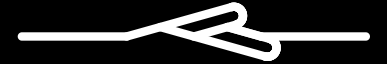

r=0.0865, dy=0.2804, Di=1.2256


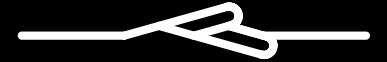

r=0.0917, dy=0.2804, Di=1.2316


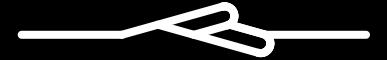

r=0.0970, dy=0.2804, Di=1.2356


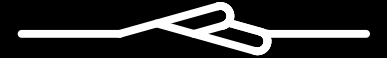

r=0.1022, dy=0.2804, Di=1.2501


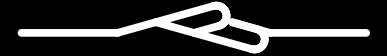

r=0.1074, dy=0.2804, Di=1.1696


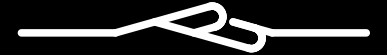

r=0.1126, dy=0.2804, Di=1.0297


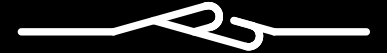

r=0.1178, dy=0.2804, Di=1.0311


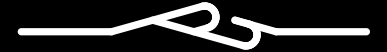

r=0.1230, dy=0.2804, Di=1.0238


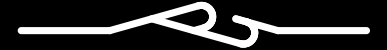

r=0.1283, dy=0.2804, Di=1.0038


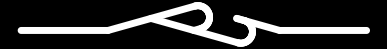

r=0.1335, dy=0.2804, Di=1.0244


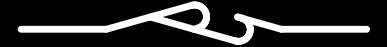

r=0.1387, dy=0.2804, Di=1.0059


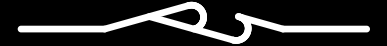

r=0.1439, dy=0.2804, Di=0.9883


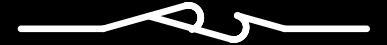

r=0.1491, dy=0.2804, Di=0.9844


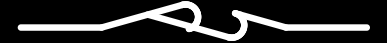

r=0.1543, dy=0.2804, Di=0.9596


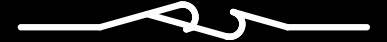

r=0.1596, dy=0.2804, Di=0.9738


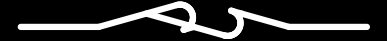

r=0.1648, dy=0.2804, Di=0.9851


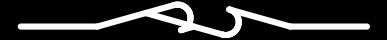

r=0.1700, dy=0.2804, Di=0.9659


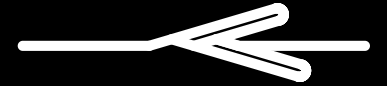

r=0.0500, dy=0.2957, Di=1.2462


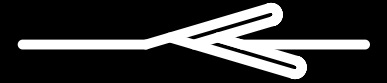

r=0.0552, dy=0.2957, Di=1.2377


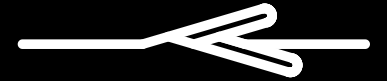

r=0.0604, dy=0.2957, Di=1.2598


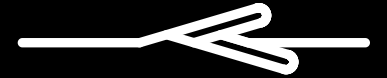

r=0.0657, dy=0.2957, Di=1.2472


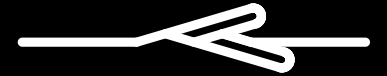

r=0.0709, dy=0.2957, Di=1.2650


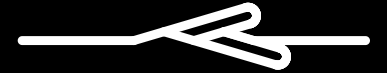

r=0.0761, dy=0.2957, Di=1.2949


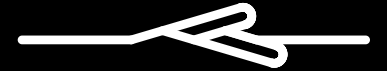

r=0.0813, dy=0.2957, Di=1.2725


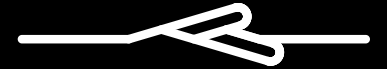

r=0.0865, dy=0.2957, Di=1.2701


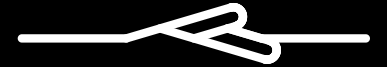

r=0.0917, dy=0.2957, Di=1.2348


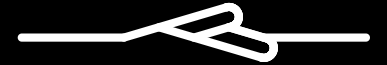

r=0.0970, dy=0.2957, Di=1.2351


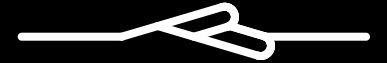

r=0.1022, dy=0.2957, Di=1.2323


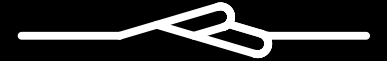

r=0.1074, dy=0.2957, Di=1.2351


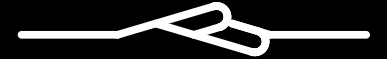

r=0.1126, dy=0.2957, Di=1.2007


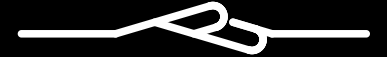

r=0.1178, dy=0.2957, Di=1.0477


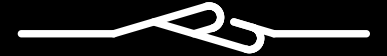

r=0.1230, dy=0.2957, Di=1.0511


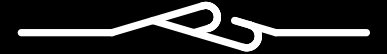

r=0.1283, dy=0.2957, Di=1.0228


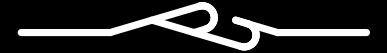

r=0.1335, dy=0.2957, Di=1.0409


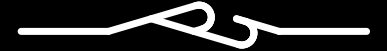

r=0.1387, dy=0.2957, Di=1.0430


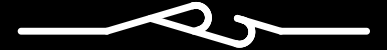

r=0.1439, dy=0.2957, Di=1.0303


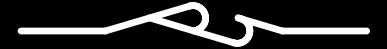

r=0.1491, dy=0.2957, Di=1.0006


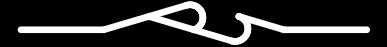

r=0.1543, dy=0.2957, Di=0.9949


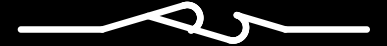

r=0.1596, dy=0.2957, Di=0.9759


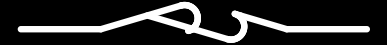

r=0.1648, dy=0.2957, Di=0.9728


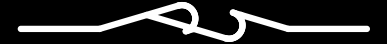

r=0.1700, dy=0.2957, Di=0.9875


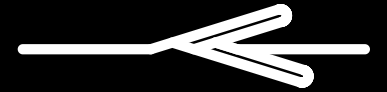

r=0.0500, dy=0.3109, Di=1.2071


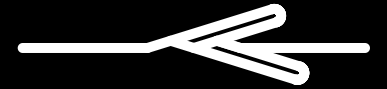

r=0.0552, dy=0.3109, Di=1.2105


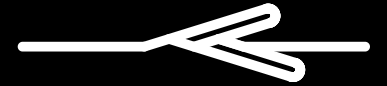

r=0.0604, dy=0.3109, Di=1.2227


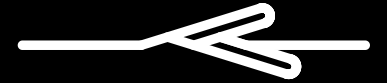

r=0.0657, dy=0.3109, Di=1.2371


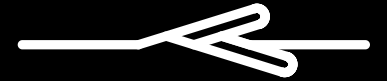

r=0.0709, dy=0.3109, Di=1.2495


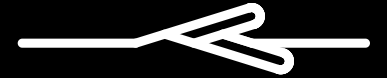

r=0.0761, dy=0.3109, Di=1.2441


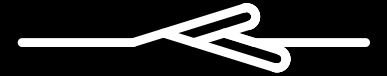

r=0.0813, dy=0.3109, Di=1.2755


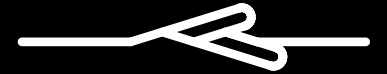

r=0.0865, dy=0.3109, Di=1.2815


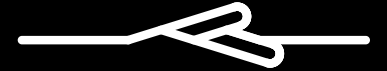

r=0.0917, dy=0.3109, Di=1.2732


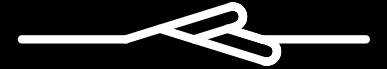

r=0.0970, dy=0.3109, Di=1.2475


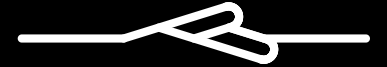

r=0.1022, dy=0.3109, Di=1.2545


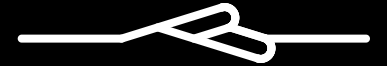

r=0.1074, dy=0.3109, Di=1.2412


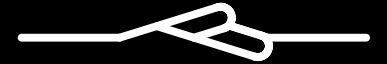

r=0.1126, dy=0.3109, Di=1.2526


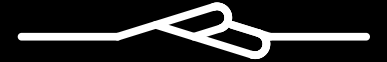

r=0.1178, dy=0.3109, Di=1.2652


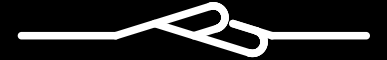

r=0.1230, dy=0.3109, Di=1.0748


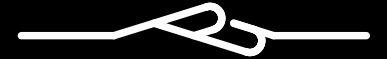

r=0.1283, dy=0.3109, Di=1.0514


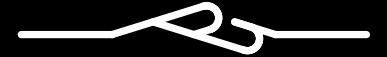

r=0.1335, dy=0.3109, Di=1.0273


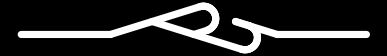

r=0.1387, dy=0.3109, Di=1.0455


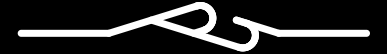

r=0.1439, dy=0.3109, Di=1.0074


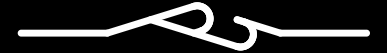

r=0.1491, dy=0.3109, Di=1.0187


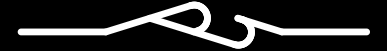

r=0.1543, dy=0.3109, Di=1.0090


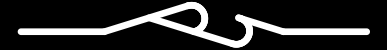

r=0.1596, dy=0.3109, Di=1.0001


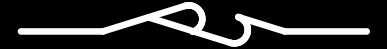

r=0.1648, dy=0.3109, Di=0.9846


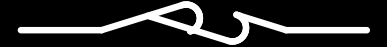

r=0.1700, dy=0.3109, Di=0.9768


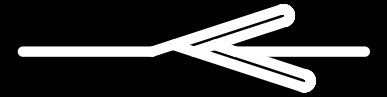

r=0.0500, dy=0.3261, Di=1.2118


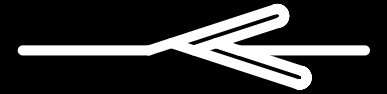

r=0.0552, dy=0.3261, Di=1.2217


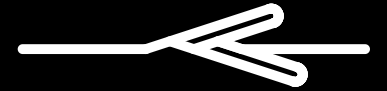

r=0.0604, dy=0.3261, Di=1.2287


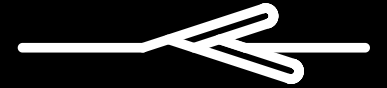

r=0.0657, dy=0.3261, Di=1.2278


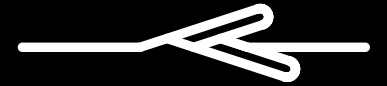

r=0.0709, dy=0.3261, Di=1.2586


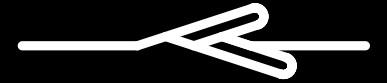

r=0.0761, dy=0.3261, Di=1.2229


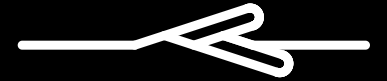

r=0.0813, dy=0.3261, Di=1.2582


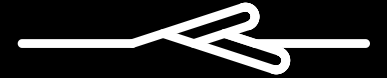

r=0.0865, dy=0.3261, Di=1.2827


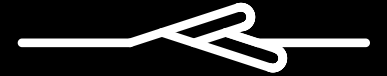

r=0.0917, dy=0.3261, Di=1.2799


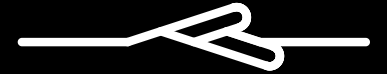

r=0.0970, dy=0.3261, Di=1.2708


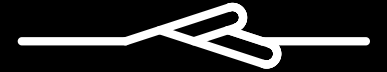

r=0.1022, dy=0.3261, Di=1.2547


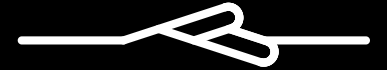

r=0.1074, dy=0.3261, Di=1.2715


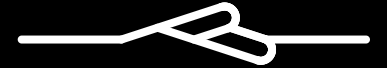

r=0.1126, dy=0.3261, Di=1.2482


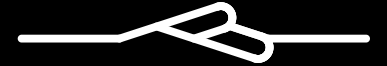

r=0.1178, dy=0.3261, Di=1.2527


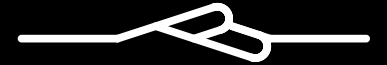

r=0.1230, dy=0.3261, Di=1.2875


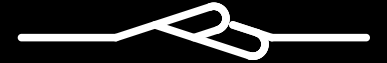

r=0.1283, dy=0.3261, Di=1.0836


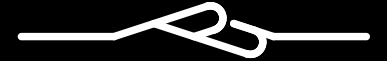

r=0.1335, dy=0.3261, Di=1.0813


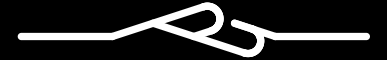

r=0.1387, dy=0.3261, Di=1.0873


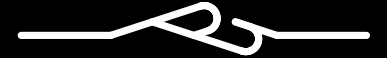

r=0.1439, dy=0.3261, Di=1.0403


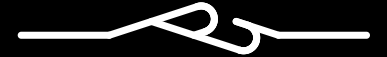

r=0.1491, dy=0.3261, Di=1.0231


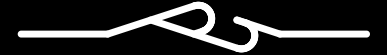

r=0.1543, dy=0.3261, Di=1.0295


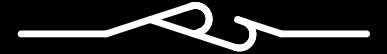

r=0.1596, dy=0.3261, Di=1.0273


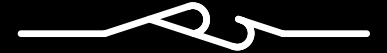

r=0.1648, dy=0.3261, Di=1.0168


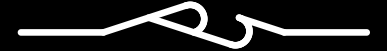

r=0.1700, dy=0.3261, Di=0.9734


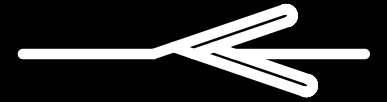

r=0.0500, dy=0.3413, Di=1.2164


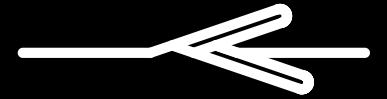

r=0.0552, dy=0.3413, Di=1.2319


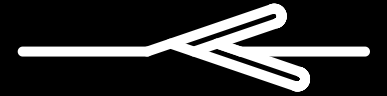

r=0.0604, dy=0.3413, Di=1.2104


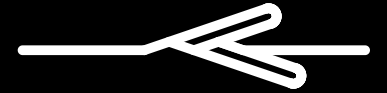

r=0.0657, dy=0.3413, Di=1.2401


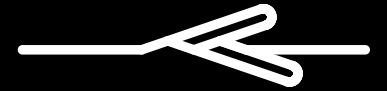

r=0.0709, dy=0.3413, Di=1.2165


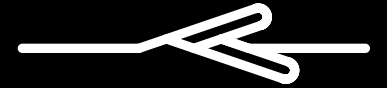

r=0.0761, dy=0.3413, Di=1.2653


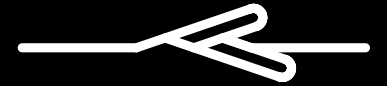

r=0.0813, dy=0.3413, Di=1.2496


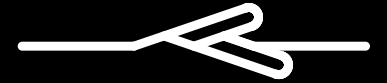

r=0.0865, dy=0.3413, Di=1.2529


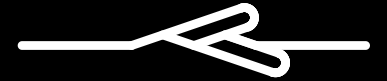

r=0.0917, dy=0.3413, Di=1.2768


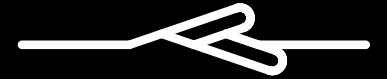

r=0.0970, dy=0.3413, Di=1.2973


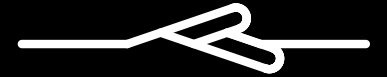

r=0.1022, dy=0.3413, Di=1.3141


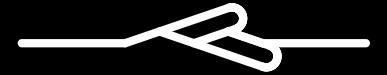

r=0.1074, dy=0.3413, Di=1.2753


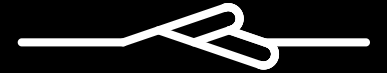

r=0.1126, dy=0.3413, Di=1.2402


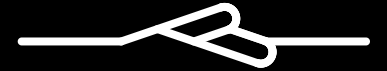

r=0.1178, dy=0.3413, Di=1.2541


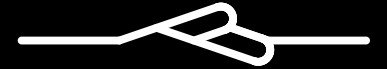

r=0.1230, dy=0.3413, Di=1.2644


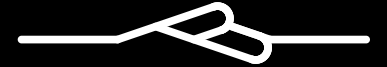

r=0.1283, dy=0.3413, Di=1.2766


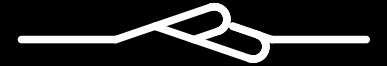

r=0.1335, dy=0.3413, Di=1.2564


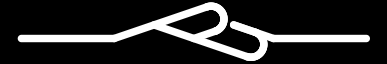

r=0.1387, dy=0.3413, Di=1.0901


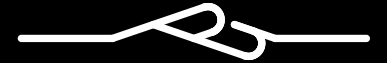

r=0.1439, dy=0.3413, Di=1.0790


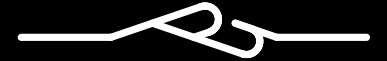

r=0.1491, dy=0.3413, Di=1.0638


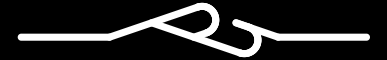

r=0.1543, dy=0.3413, Di=1.0504


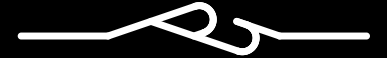

r=0.1596, dy=0.3413, Di=1.0447


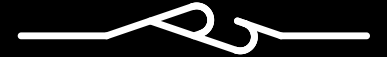

r=0.1648, dy=0.3413, Di=1.0186


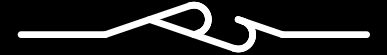

r=0.1700, dy=0.3413, Di=1.0354


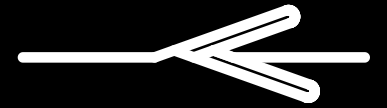

r=0.0500, dy=0.3565, Di=1.1794


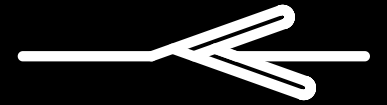

r=0.0552, dy=0.3565, Di=1.1927


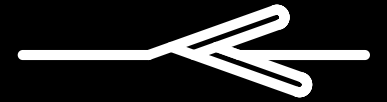

r=0.0604, dy=0.3565, Di=1.2179


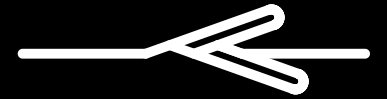

r=0.0657, dy=0.3565, Di=1.2136


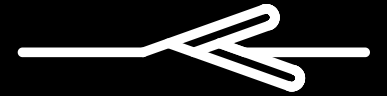

r=0.0709, dy=0.3565, Di=1.2454


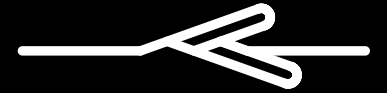

r=0.0761, dy=0.3565, Di=1.2199


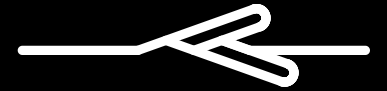

r=0.0813, dy=0.3565, Di=1.2698


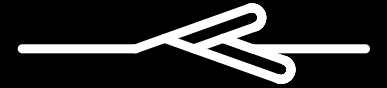

r=0.0865, dy=0.3565, Di=1.2408


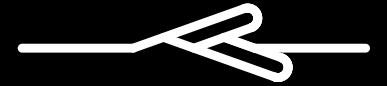

r=0.0917, dy=0.3565, Di=1.2574


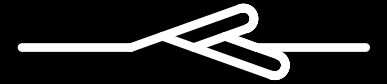

r=0.0970, dy=0.3565, Di=1.2563


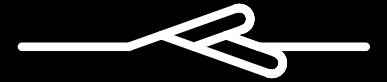

r=0.1022, dy=0.3565, Di=1.3109


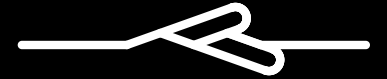

r=0.1074, dy=0.3565, Di=1.3045


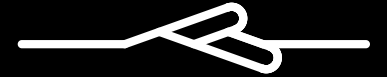

r=0.1126, dy=0.3565, Di=1.2777


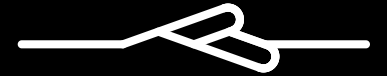

r=0.1178, dy=0.3565, Di=1.2523


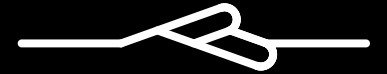

r=0.1230, dy=0.3565, Di=1.2619


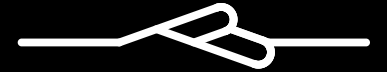

r=0.1283, dy=0.3565, Di=1.2730


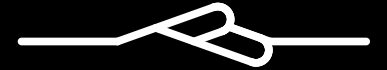

r=0.1335, dy=0.3565, Di=1.2854


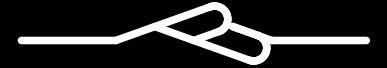

r=0.1387, dy=0.3565, Di=1.3020


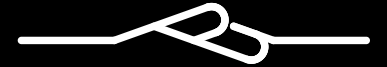

r=0.1439, dy=0.3565, Di=1.1082


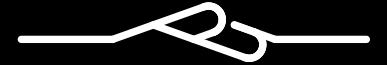

r=0.1491, dy=0.3565, Di=1.0912


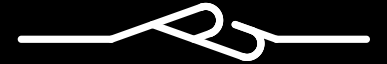

r=0.1543, dy=0.3565, Di=1.0975


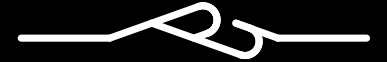

r=0.1596, dy=0.3565, Di=1.0454


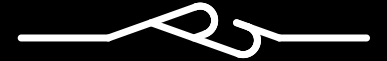

r=0.1648, dy=0.3565, Di=1.0458


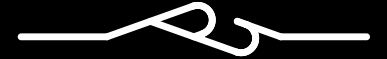

r=0.1700, dy=0.3565, Di=1.0482


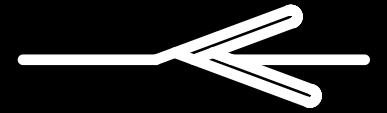

r=0.0500, dy=0.3717, Di=1.1974


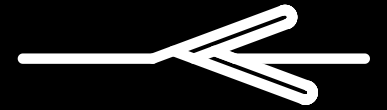

r=0.0552, dy=0.3717, Di=1.1952


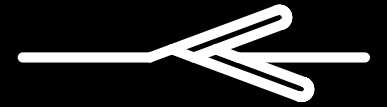

r=0.0604, dy=0.3717, Di=1.1924


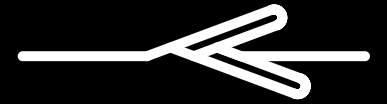

r=0.0657, dy=0.3717, Di=1.1998


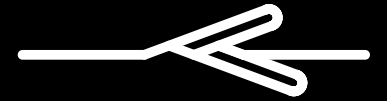

r=0.0709, dy=0.3717, Di=1.1720


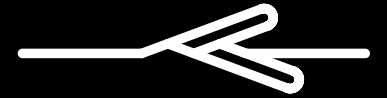

r=0.0761, dy=0.3717, Di=1.2427


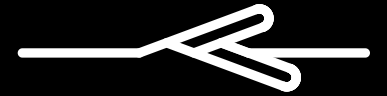

r=0.0813, dy=0.3717, Di=1.2149


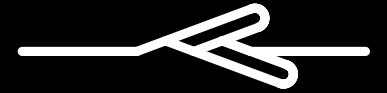

r=0.0865, dy=0.3717, Di=1.2685


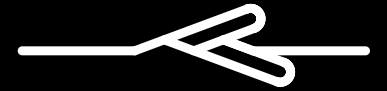

r=0.0917, dy=0.3717, Di=1.2428


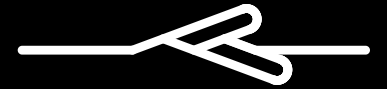

r=0.0970, dy=0.3717, Di=1.2695


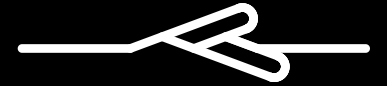

r=0.1022, dy=0.3717, Di=1.2539


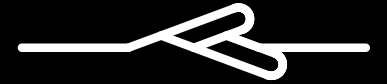

r=0.1074, dy=0.3717, Di=1.3100


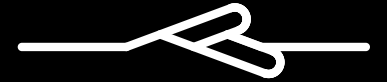

r=0.1126, dy=0.3717, Di=1.3028


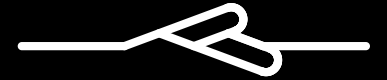

r=0.1178, dy=0.3717, Di=1.2626


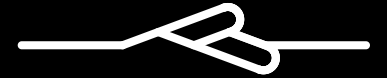

r=0.1230, dy=0.3717, Di=1.2647


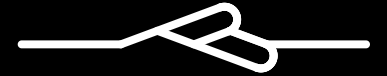

r=0.1283, dy=0.3717, Di=1.2689


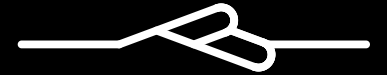

r=0.1335, dy=0.3717, Di=1.2869


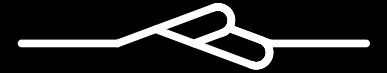

r=0.1387, dy=0.3717, Di=1.2948


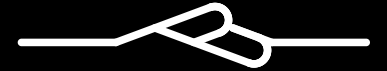

r=0.1439, dy=0.3717, Di=1.3044


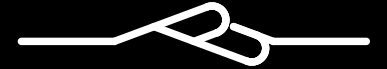

r=0.1491, dy=0.3717, Di=1.1145


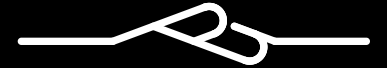

r=0.1543, dy=0.3717, Di=1.0971


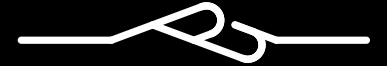

r=0.1596, dy=0.3717, Di=1.0682


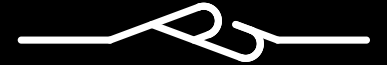

r=0.1648, dy=0.3717, Di=1.0702


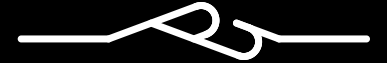

r=0.1700, dy=0.3717, Di=1.0426


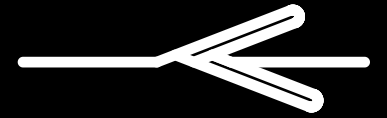

r=0.0500, dy=0.3870, Di=1.1815


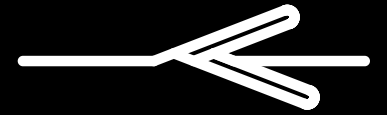

r=0.0552, dy=0.3870, Di=1.1912


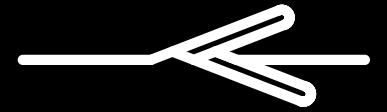

r=0.0604, dy=0.3870, Di=1.2387


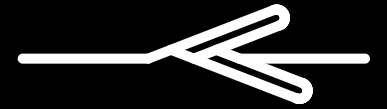

r=0.0657, dy=0.3870, Di=1.1931


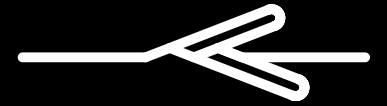

r=0.0709, dy=0.3870, Di=1.2029


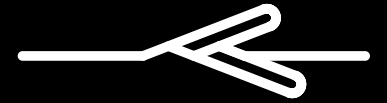

r=0.0761, dy=0.3870, Di=1.1569


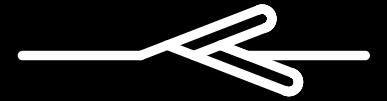

r=0.0813, dy=0.3870, Di=1.2337


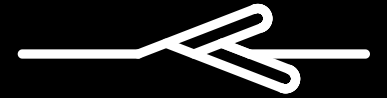

r=0.0865, dy=0.3870, Di=1.2219


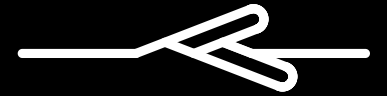

r=0.0917, dy=0.3870, Di=1.2727


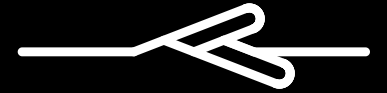

r=0.0970, dy=0.3870, Di=1.2547


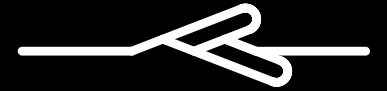

r=0.1022, dy=0.3870, Di=1.2882


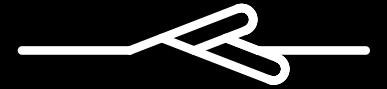

r=0.1074, dy=0.3870, Di=1.2731


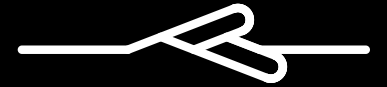

r=0.1126, dy=0.3870, Di=1.3029


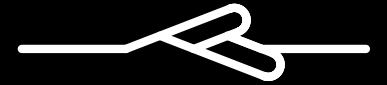

r=0.1178, dy=0.3870, Di=1.3056


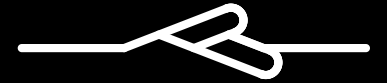

r=0.1230, dy=0.3870, Di=1.2649


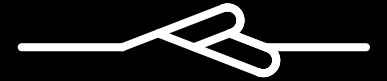

r=0.1283, dy=0.3870, Di=1.2652


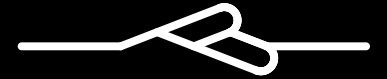

r=0.1335, dy=0.3870, Di=1.2770


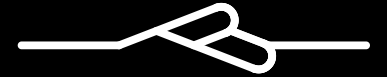

r=0.1387, dy=0.3870, Di=1.2814


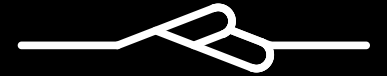

r=0.1439, dy=0.3870, Di=1.2952


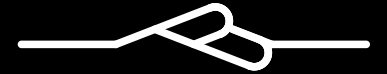

r=0.1491, dy=0.3870, Di=1.3056


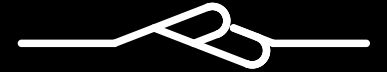

r=0.1543, dy=0.3870, Di=1.1140


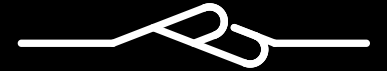

r=0.1596, dy=0.3870, Di=1.0974


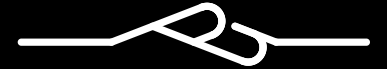

r=0.1648, dy=0.3870, Di=1.0734


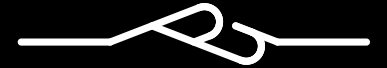

r=0.1700, dy=0.3870, Di=1.0484


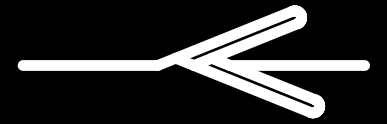

r=0.0500, dy=0.4022, Di=1.1726


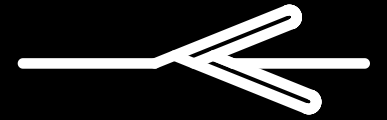

r=0.0552, dy=0.4022, Di=1.1703


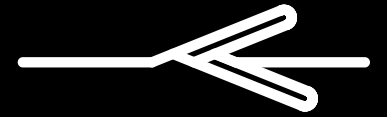

r=0.0604, dy=0.4022, Di=1.1662


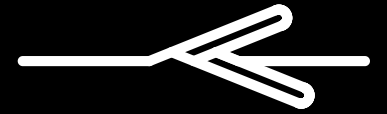

r=0.0657, dy=0.4022, Di=1.2226


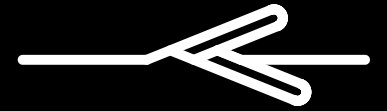

r=0.0709, dy=0.4022, Di=1.2004


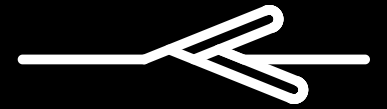

r=0.0761, dy=0.4022, Di=1.2089


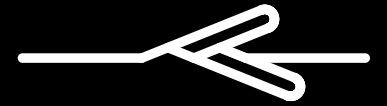

r=0.0813, dy=0.4022, Di=1.1908


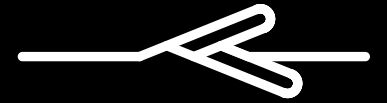

r=0.0865, dy=0.4022, Di=1.2299


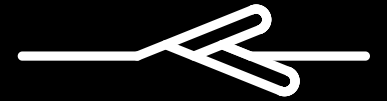

r=0.0917, dy=0.4022, Di=1.2271


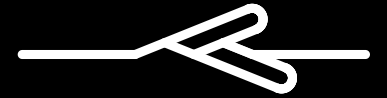

r=0.0970, dy=0.4022, Di=1.2589


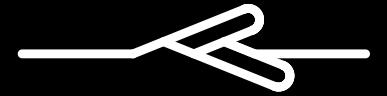

r=0.1022, dy=0.4022, Di=1.2723


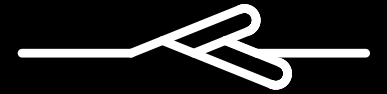

r=0.1074, dy=0.4022, Di=1.2702


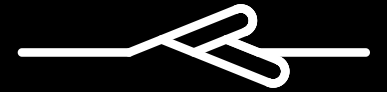

r=0.1126, dy=0.4022, Di=1.2777


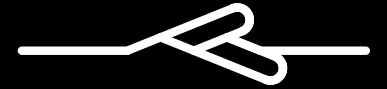

r=0.1178, dy=0.4022, Di=1.2970


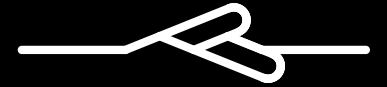

r=0.1230, dy=0.4022, Di=1.3162


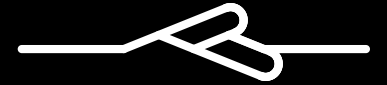

r=0.1283, dy=0.4022, Di=1.2730


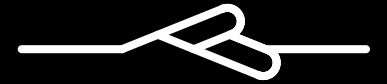

r=0.1335, dy=0.4022, Di=1.2779


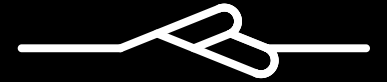

r=0.1387, dy=0.4022, Di=1.2844


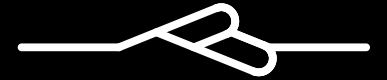

r=0.1439, dy=0.4022, Di=1.2824


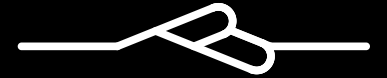

r=0.1491, dy=0.4022, Di=1.3083


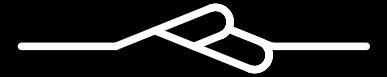

r=0.1543, dy=0.4022, Di=1.3349


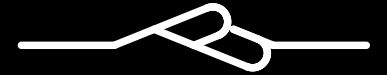

r=0.1596, dy=0.4022, Di=1.1852


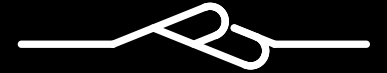

r=0.1648, dy=0.4022, Di=1.1198


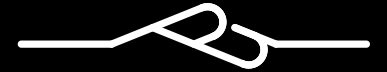

r=0.1700, dy=0.4022, Di=1.0761


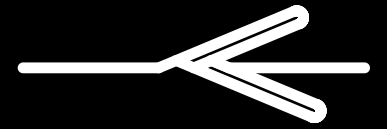

r=0.0500, dy=0.4174, Di=1.1707


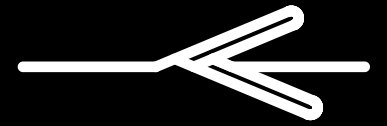

r=0.0552, dy=0.4174, Di=1.1816


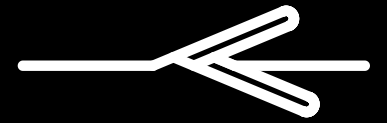

r=0.0604, dy=0.4174, Di=1.1953


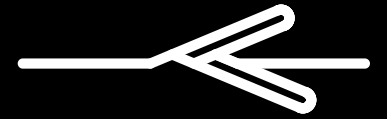

r=0.0657, dy=0.4174, Di=1.1670


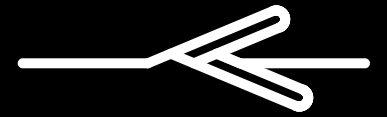

r=0.0709, dy=0.4174, Di=1.2117


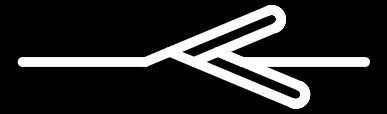

r=0.0761, dy=0.4174, Di=1.2161


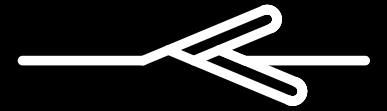

r=0.0813, dy=0.4174, Di=1.2282


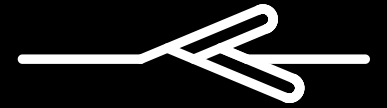

r=0.0865, dy=0.4174, Di=1.2449


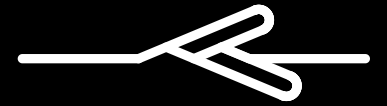

r=0.0917, dy=0.4174, Di=1.1877


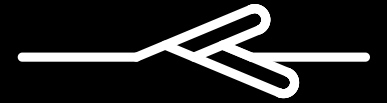

r=0.0970, dy=0.4174, Di=1.2032


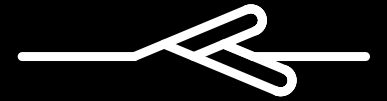

r=0.1022, dy=0.4174, Di=1.2598


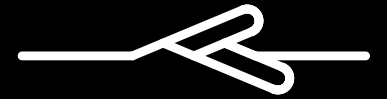

r=0.1074, dy=0.4174, Di=1.2747


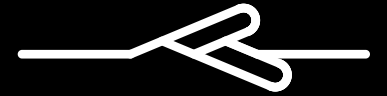

r=0.1126, dy=0.4174, Di=1.2637


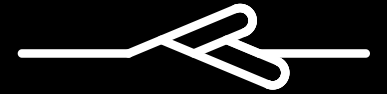

r=0.1178, dy=0.4174, Di=1.2484


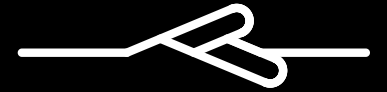

r=0.1230, dy=0.4174, Di=1.3098


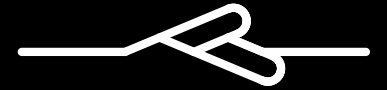

r=0.1283, dy=0.4174, Di=1.3132


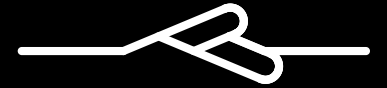

r=0.1335, dy=0.4174, Di=1.2691


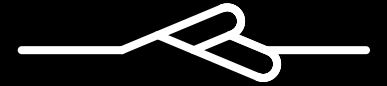

r=0.1387, dy=0.4174, Di=1.2846


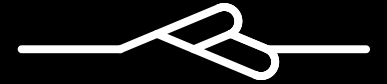

r=0.1439, dy=0.4174, Di=1.2865


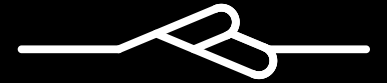

r=0.1491, dy=0.4174, Di=1.2825


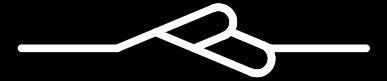

r=0.1543, dy=0.4174, Di=1.3077


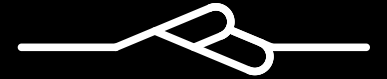

r=0.1596, dy=0.4174, Di=1.3201


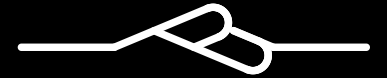

r=0.1648, dy=0.4174, Di=1.3008


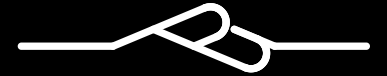

r=0.1700, dy=0.4174, Di=1.1331


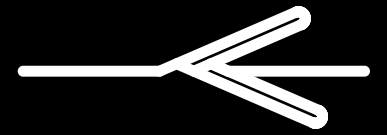

r=0.0500, dy=0.4326, Di=1.1419


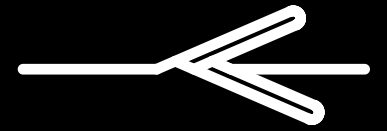

r=0.0552, dy=0.4326, Di=1.1759


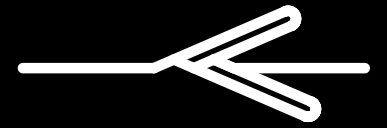

r=0.0604, dy=0.4326, Di=1.1787


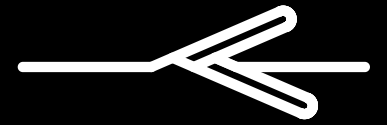

r=0.0657, dy=0.4326, Di=1.2072


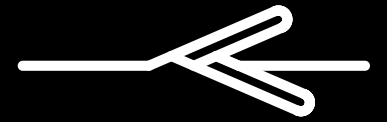

r=0.0709, dy=0.4326, Di=1.1956


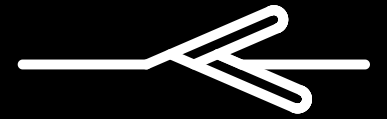

r=0.0761, dy=0.4326, Di=1.2169


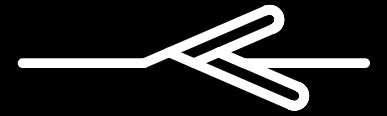

r=0.0813, dy=0.4326, Di=1.2116


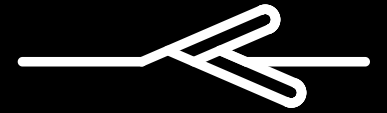

r=0.0865, dy=0.4326, Di=1.1927


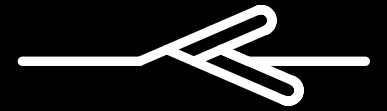

r=0.0917, dy=0.4326, Di=1.2468


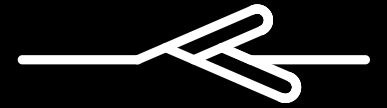

r=0.0970, dy=0.4326, Di=1.1875


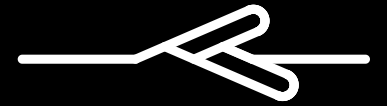

r=0.1022, dy=0.4326, Di=1.2319


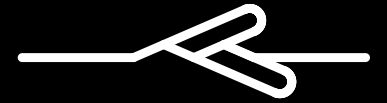

r=0.1074, dy=0.4326, Di=1.2671


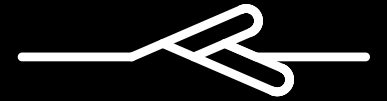

r=0.1126, dy=0.4326, Di=1.2592


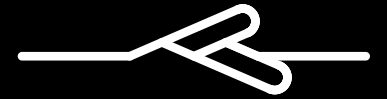

r=0.1178, dy=0.4326, Di=1.2603


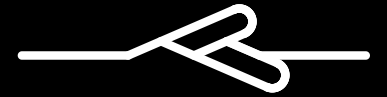

r=0.1230, dy=0.4326, Di=1.2387


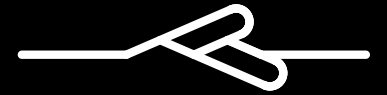

r=0.1283, dy=0.4326, Di=1.3041


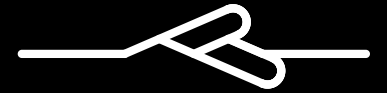

r=0.1335, dy=0.4326, Di=1.3180


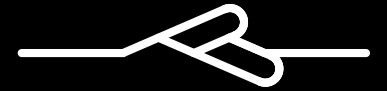

r=0.1387, dy=0.4326, Di=1.2717


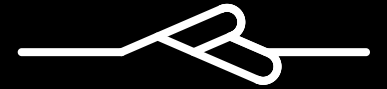

r=0.1439, dy=0.4326, Di=1.2787


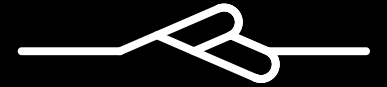

r=0.1491, dy=0.4326, Di=1.2867


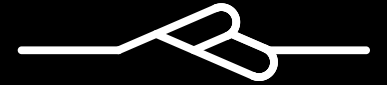

r=0.1543, dy=0.4326, Di=1.2979


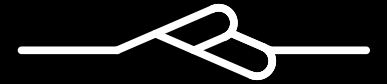

r=0.1596, dy=0.4326, Di=1.3025


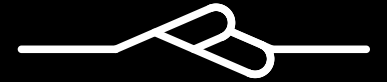

r=0.1648, dy=0.4326, Di=1.3314


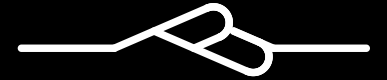

r=0.1700, dy=0.4326, Di=1.3369


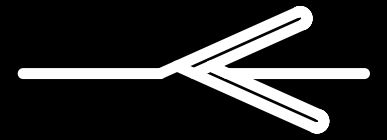

r=0.0500, dy=0.4478, Di=1.1406


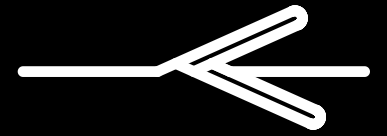

r=0.0552, dy=0.4478, Di=1.1732


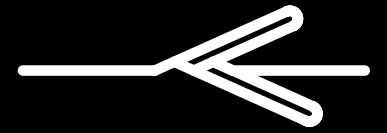

r=0.0604, dy=0.4478, Di=1.1396


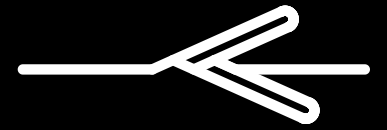

r=0.0657, dy=0.4478, Di=1.1597


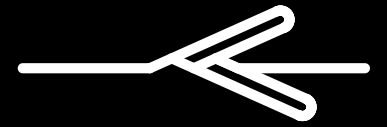

r=0.0709, dy=0.4478, Di=1.1649


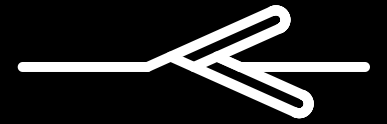

r=0.0761, dy=0.4478, Di=1.1702


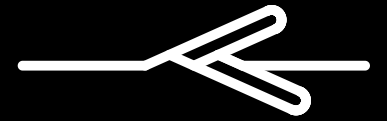

r=0.0813, dy=0.4478, Di=1.2015


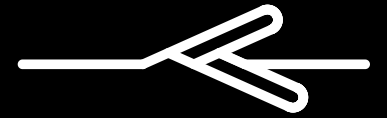

r=0.0865, dy=0.4478, Di=1.2105


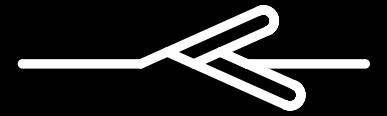

r=0.0917, dy=0.4478, Di=1.1967


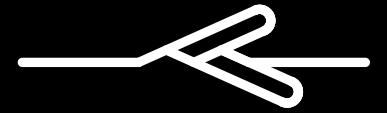

r=0.0970, dy=0.4478, Di=1.2493


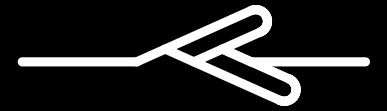

r=0.1022, dy=0.4478, Di=1.2196


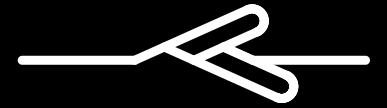

r=0.1074, dy=0.4478, Di=1.2411


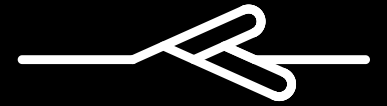

r=0.1126, dy=0.4478, Di=1.2457


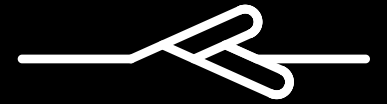

r=0.1178, dy=0.4478, Di=1.2679


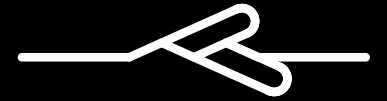

r=0.1230, dy=0.4478, Di=1.2211


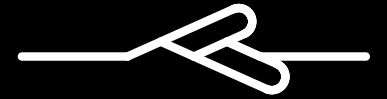

r=0.1283, dy=0.4478, Di=1.2409


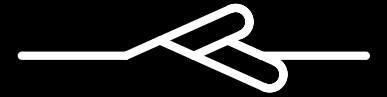

r=0.1335, dy=0.4478, Di=1.3162


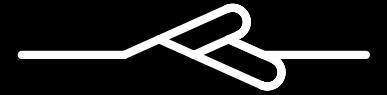

r=0.1387, dy=0.4478, Di=1.3089


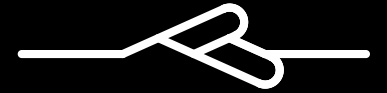

r=0.1439, dy=0.4478, Di=1.2702


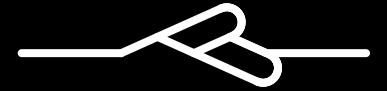

r=0.1491, dy=0.4478, Di=1.2783


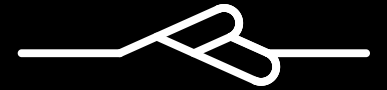

r=0.1543, dy=0.4478, Di=1.2937


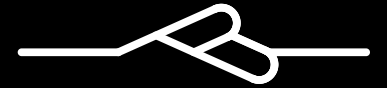

r=0.1596, dy=0.4478, Di=1.3059


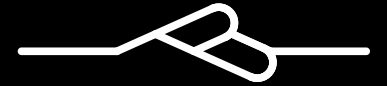

r=0.1648, dy=0.4478, Di=1.3039


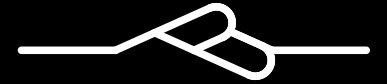

r=0.1700, dy=0.4478, Di=1.3325


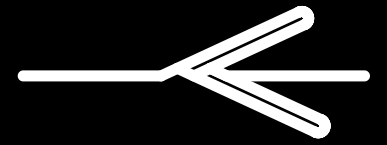

r=0.0500, dy=0.4630, Di=1.1271


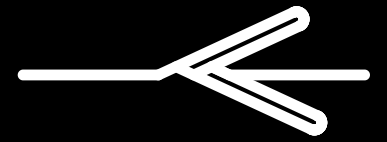

r=0.0552, dy=0.4630, Di=1.1399


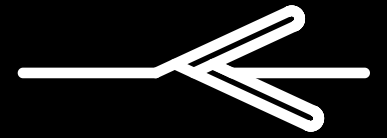

r=0.0604, dy=0.4630, Di=1.1751


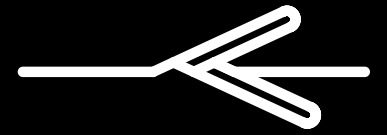

r=0.0657, dy=0.4630, Di=1.1839


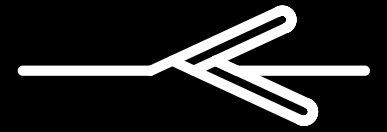

r=0.0709, dy=0.4630, Di=1.1758


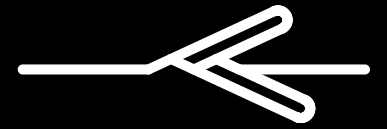

r=0.0761, dy=0.4630, Di=1.1757


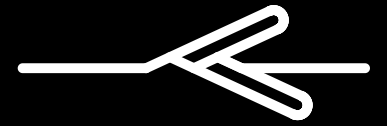

r=0.0813, dy=0.4630, Di=1.1882


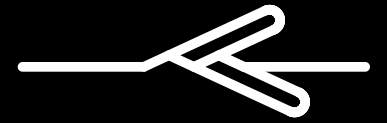

r=0.0865, dy=0.4630, Di=1.1709


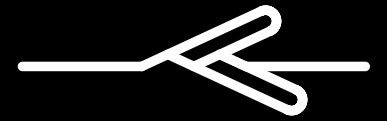

r=0.0917, dy=0.4630, Di=1.2040


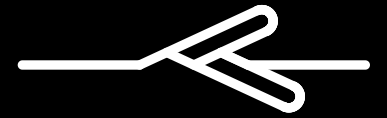

r=0.0970, dy=0.4630, Di=1.1950


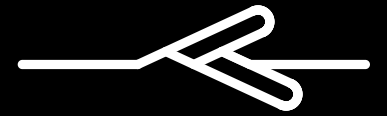

r=0.1022, dy=0.4630, Di=1.2463


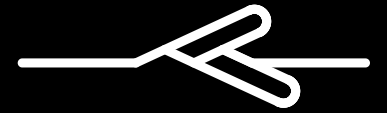

r=0.1074, dy=0.4630, Di=1.2177


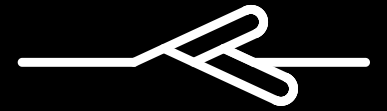

r=0.1126, dy=0.4630, Di=1.2470


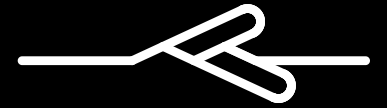

r=0.1178, dy=0.4630, Di=1.2526


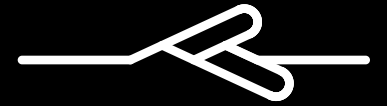

r=0.1230, dy=0.4630, Di=1.2637


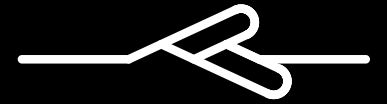

r=0.1283, dy=0.4630, Di=1.2192


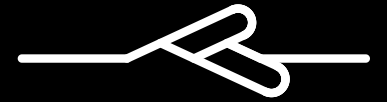

r=0.1335, dy=0.4630, Di=1.2418


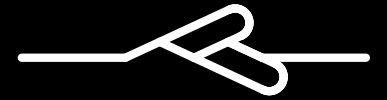

r=0.1387, dy=0.4630, Di=1.3163


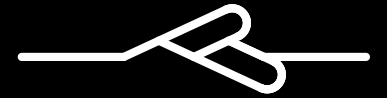

r=0.1439, dy=0.4630, Di=1.3169


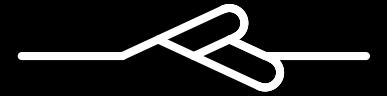

r=0.1491, dy=0.4630, Di=1.2677


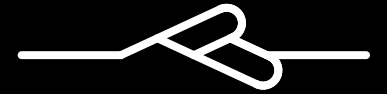

r=0.1543, dy=0.4630, Di=1.2882


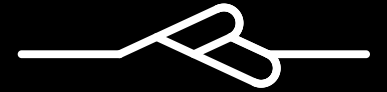

r=0.1596, dy=0.4630, Di=1.2928


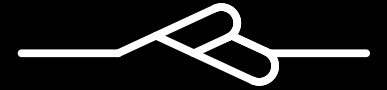

r=0.1648, dy=0.4630, Di=1.2975


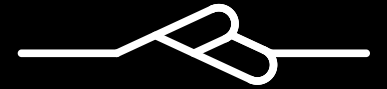

r=0.1700, dy=0.4630, Di=1.3230


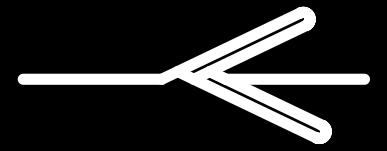

r=0.0500, dy=0.4783, Di=1.1186


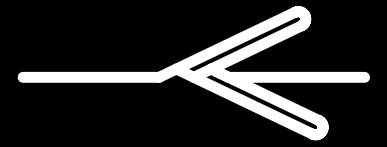

r=0.0552, dy=0.4783, Di=1.1378


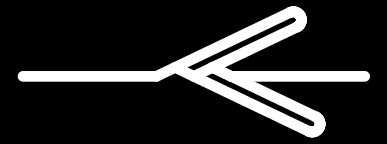

r=0.0604, dy=0.4783, Di=1.1111


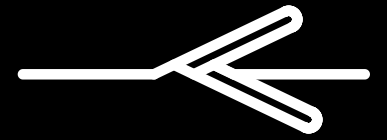

r=0.0657, dy=0.4783, Di=1.1515


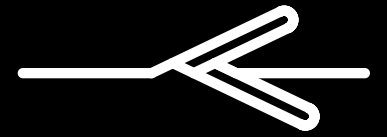

r=0.0709, dy=0.4783, Di=1.1529


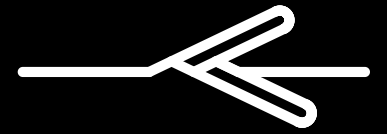

r=0.0761, dy=0.4783, Di=1.2104


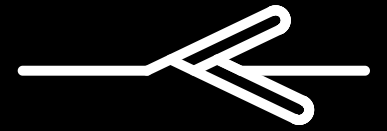

r=0.0813, dy=0.4783, Di=1.1716


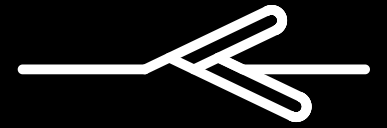

r=0.0865, dy=0.4783, Di=1.2120


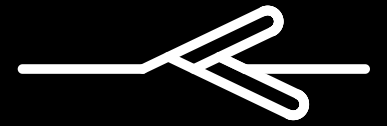

r=0.0917, dy=0.4783, Di=1.1468


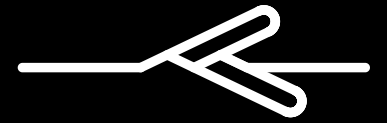

r=0.0970, dy=0.4783, Di=1.2037


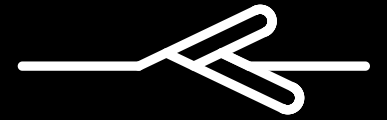

r=0.1022, dy=0.4783, Di=1.1825


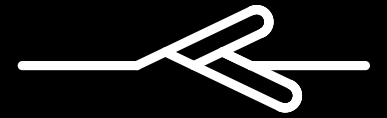

r=0.1074, dy=0.4783, Di=1.2139


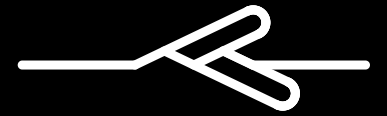

r=0.1126, dy=0.4783, Di=1.2134


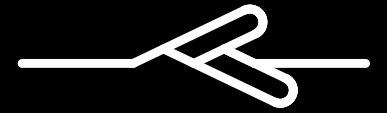

r=0.1178, dy=0.4783, Di=1.1989


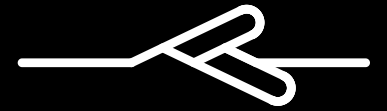

r=0.1230, dy=0.4783, Di=1.2507


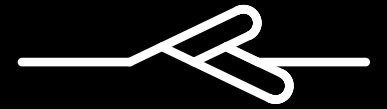

r=0.1283, dy=0.4783, Di=1.2703


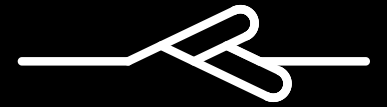

r=0.1335, dy=0.4783, Di=1.2246


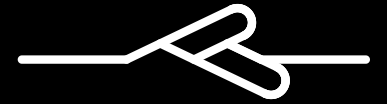

r=0.1387, dy=0.4783, Di=1.2503


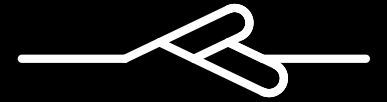

r=0.1439, dy=0.4783, Di=1.3159


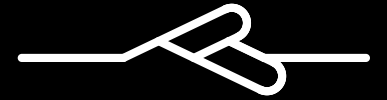

r=0.1491, dy=0.4783, Di=1.3227


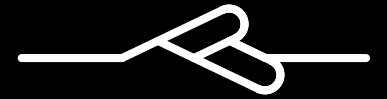

r=0.1543, dy=0.4783, Di=1.2856


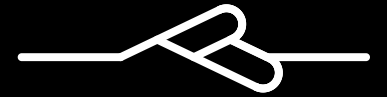

r=0.1596, dy=0.4783, Di=1.2883


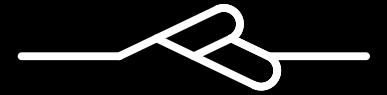

r=0.1648, dy=0.4783, Di=1.2912


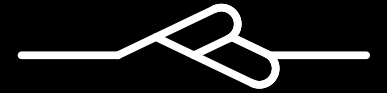

r=0.1700, dy=0.4783, Di=1.3025


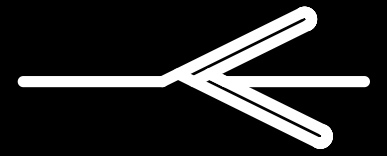

r=0.0500, dy=0.4935, Di=1.1157


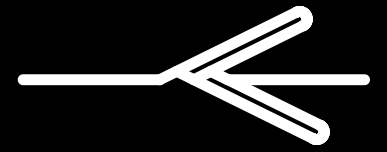

r=0.0552, dy=0.4935, Di=1.1242


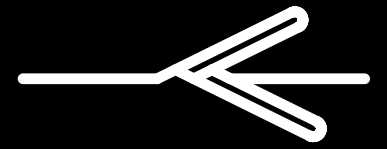

r=0.0604, dy=0.4935, Di=1.1418


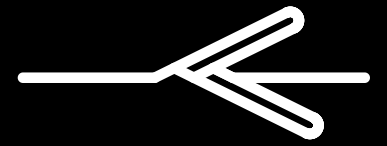

r=0.0657, dy=0.4935, Di=1.1766


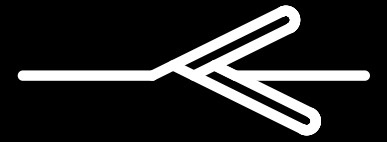

r=0.0709, dy=0.4935, Di=1.1444


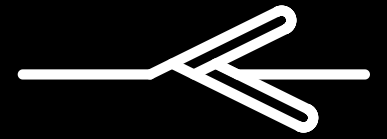

r=0.0761, dy=0.4935, Di=1.1546


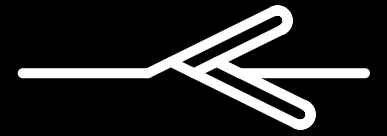

r=0.0813, dy=0.4935, Di=1.1686


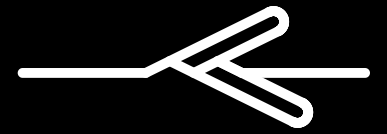

r=0.0865, dy=0.4935, Di=1.1484


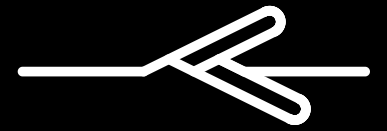

r=0.0917, dy=0.4935, Di=1.2202


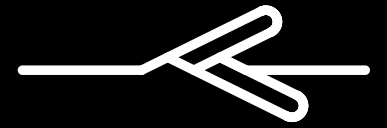

r=0.0970, dy=0.4935, Di=1.2145


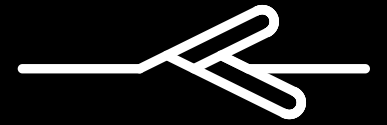

r=0.1022, dy=0.4935, Di=1.1866


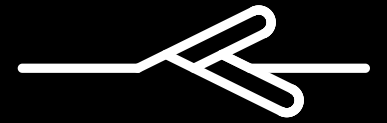

r=0.1074, dy=0.4935, Di=1.2449


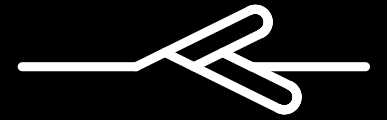

r=0.1126, dy=0.4935, Di=1.2191


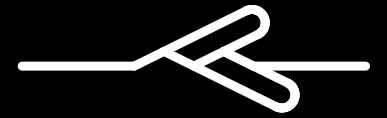

r=0.1178, dy=0.4935, Di=1.2133


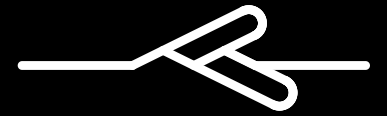

r=0.1230, dy=0.4935, Di=1.2451


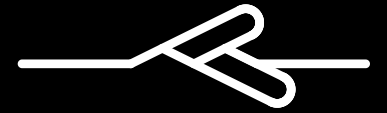

r=0.1283, dy=0.4935, Di=1.2507


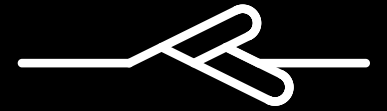

r=0.1335, dy=0.4935, Di=1.2711


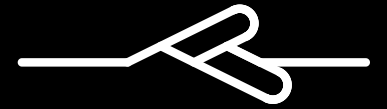

r=0.1387, dy=0.4935, Di=1.2153


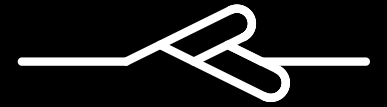

r=0.1439, dy=0.4935, Di=1.2402


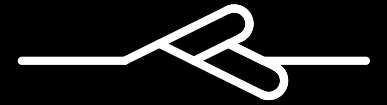

r=0.1491, dy=0.4935, Di=1.3034


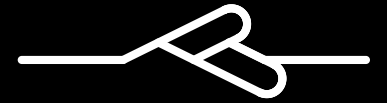

r=0.1543, dy=0.4935, Di=1.3508


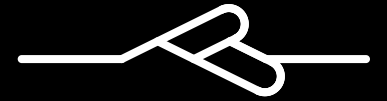

r=0.1596, dy=0.4935, Di=1.2736


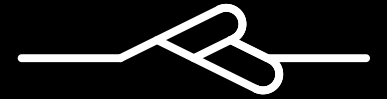

r=0.1648, dy=0.4935, Di=1.2781


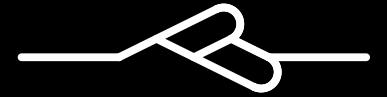

r=0.1700, dy=0.4935, Di=1.2915


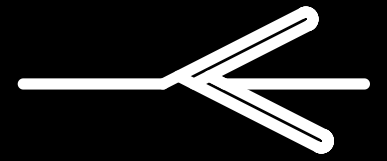

r=0.0500, dy=0.5087, Di=1.1039


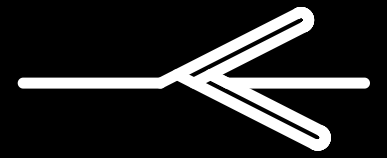

r=0.0552, dy=0.5087, Di=1.1087


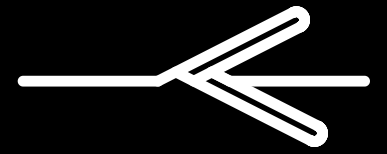

r=0.0604, dy=0.5087, Di=1.1349


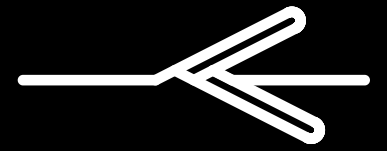

r=0.0657, dy=0.5087, Di=1.1506


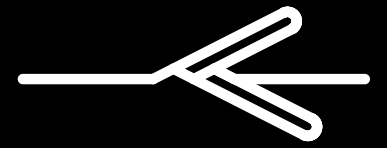

r=0.0709, dy=0.5087, Di=1.1811


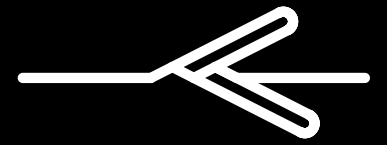

r=0.0761, dy=0.5087, Di=1.1837


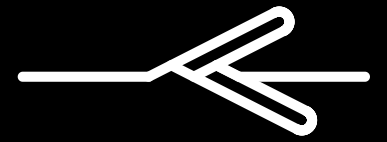

r=0.0813, dy=0.5087, Di=1.1825


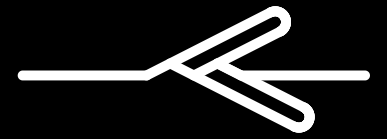

r=0.0865, dy=0.5087, Di=1.1547


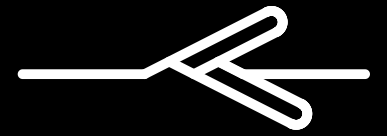

r=0.0917, dy=0.5087, Di=1.1956


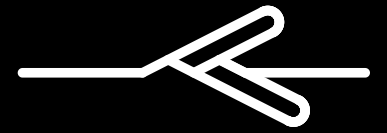

r=0.0970, dy=0.5087, Di=1.1756


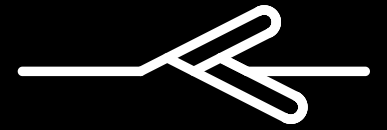

r=0.1022, dy=0.5087, Di=1.2163


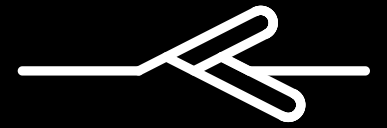

r=0.1074, dy=0.5087, Di=1.1865


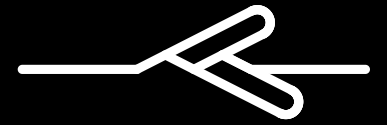

r=0.1126, dy=0.5087, Di=1.2453


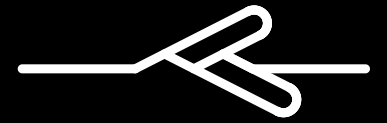

r=0.1178, dy=0.5087, Di=1.2122


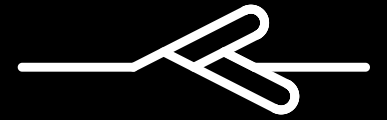

r=0.1230, dy=0.5087, Di=1.2378


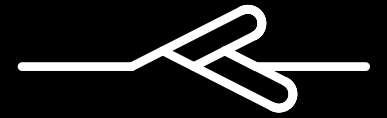

r=0.1283, dy=0.5087, Di=1.2477


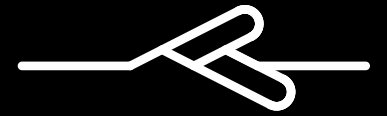

r=0.1335, dy=0.5087, Di=1.2536


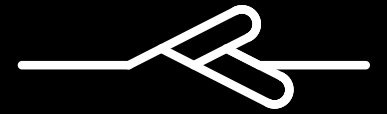

r=0.1387, dy=0.5087, Di=1.2703


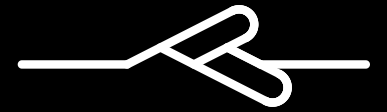

r=0.1439, dy=0.5087, Di=1.2366


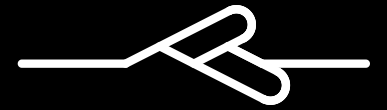

r=0.1491, dy=0.5087, Di=1.2544


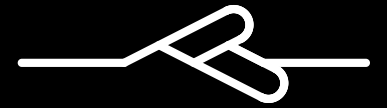

r=0.1543, dy=0.5087, Di=1.3150


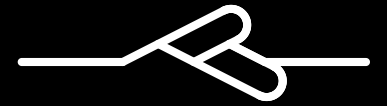

r=0.1596, dy=0.5087, Di=1.2740


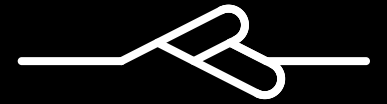

r=0.1648, dy=0.5087, Di=1.3012


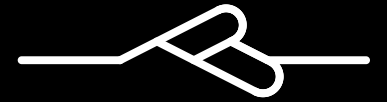

r=0.1700, dy=0.5087, Di=1.2928


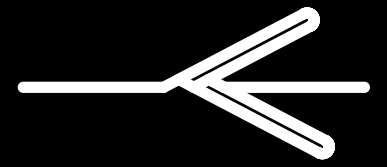

r=0.0500, dy=0.5239, Di=1.1258


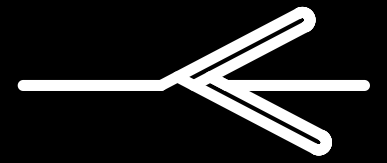

r=0.0552, dy=0.5239, Di=1.1146


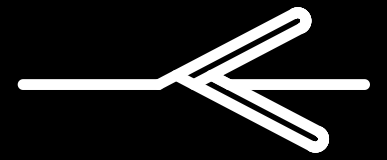

r=0.0604, dy=0.5239, Di=1.1334


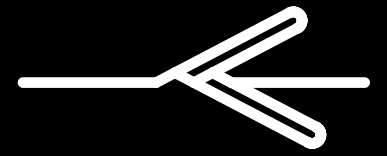

r=0.0657, dy=0.5239, Di=1.1371


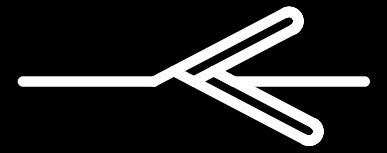

r=0.0709, dy=0.5239, Di=1.1221


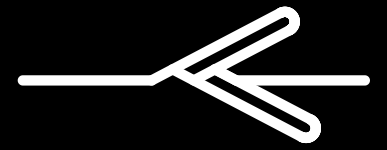

r=0.0761, dy=0.5239, Di=1.1381


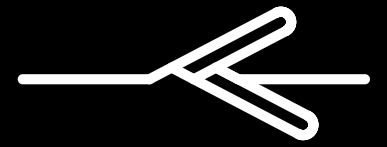

r=0.0813, dy=0.5239, Di=1.1643


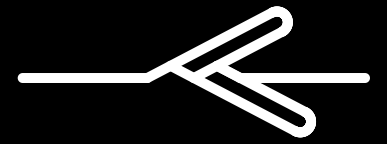

r=0.0865, dy=0.5239, Di=1.1598


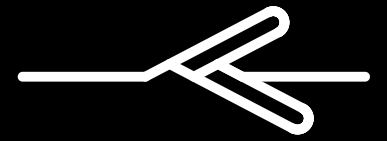

r=0.0917, dy=0.5239, Di=1.1590


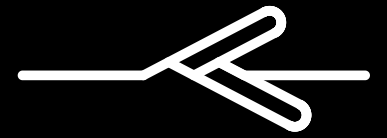

r=0.0970, dy=0.5239, Di=1.1938


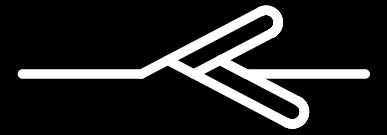

r=0.1022, dy=0.5239, Di=1.1975


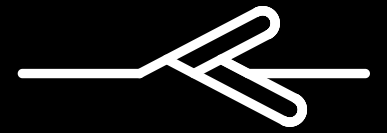

r=0.1074, dy=0.5239, Di=1.2293


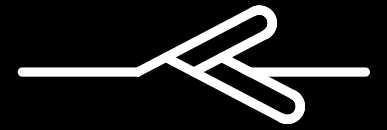

r=0.1126, dy=0.5239, Di=1.1897


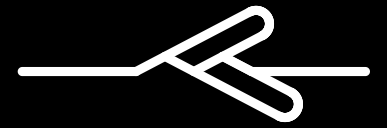

r=0.1178, dy=0.5239, Di=1.2197


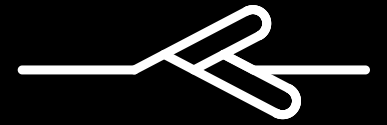

r=0.1230, dy=0.5239, Di=1.2272


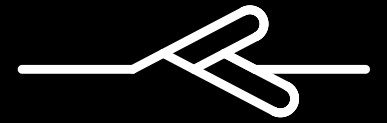

r=0.1283, dy=0.5239, Di=1.2422


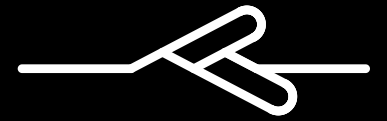

r=0.1335, dy=0.5239, Di=1.2513


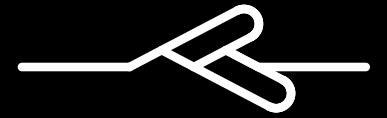

r=0.1387, dy=0.5239, Di=1.2545


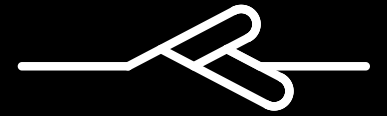

r=0.1439, dy=0.5239, Di=1.2206


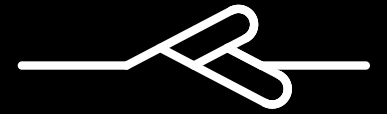

r=0.1491, dy=0.5239, Di=1.2306


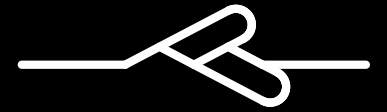

r=0.1543, dy=0.5239, Di=1.3029


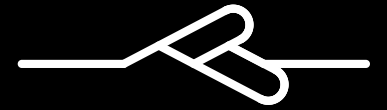

r=0.1596, dy=0.5239, Di=1.3097


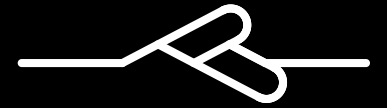

r=0.1648, dy=0.5239, Di=1.2754


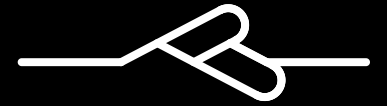

r=0.1700, dy=0.5239, Di=1.2946


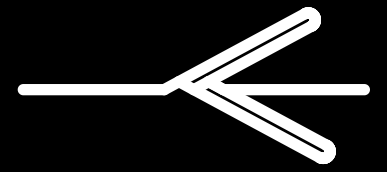

r=0.0500, dy=0.5391, Di=1.0957


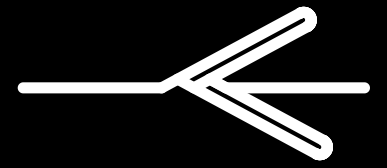

r=0.0552, dy=0.5391, Di=1.1035


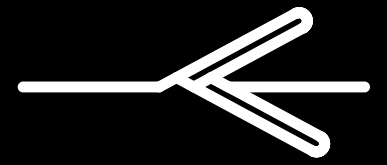

r=0.0604, dy=0.5391, Di=1.1125


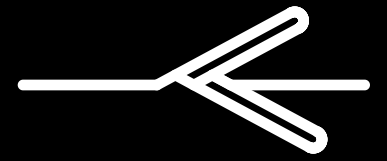

r=0.0657, dy=0.5391, Di=1.1309


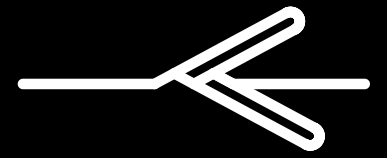

r=0.0709, dy=0.5391, Di=1.1435


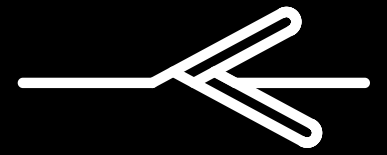

r=0.0761, dy=0.5391, Di=1.1840


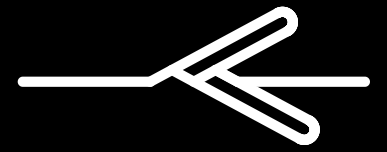

r=0.0813, dy=0.5391, Di=1.1488


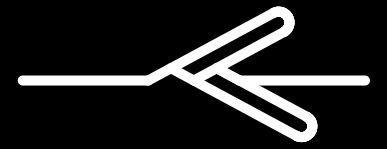

r=0.0865, dy=0.5391, Di=1.1589


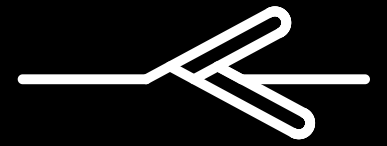

r=0.0917, dy=0.5391, Di=1.1748


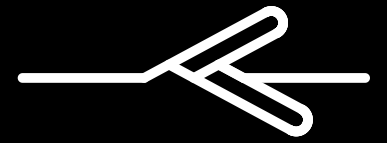

r=0.0970, dy=0.5391, Di=1.1370


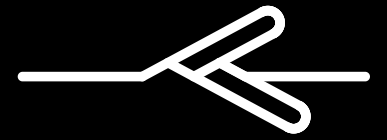

r=0.1022, dy=0.5391, Di=1.1875


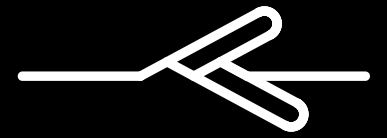

r=0.1074, dy=0.5391, Di=1.2183


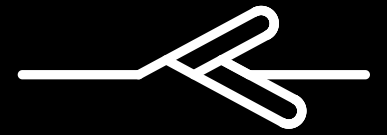

r=0.1126, dy=0.5391, Di=1.1587


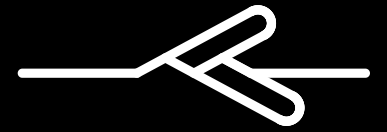

r=0.1178, dy=0.5391, Di=1.1844


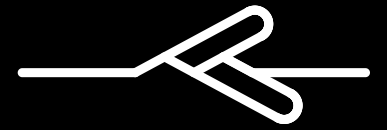

r=0.1230, dy=0.5391, Di=1.2166


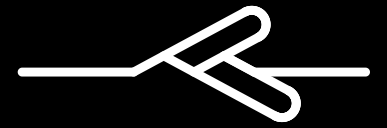

r=0.1283, dy=0.5391, Di=1.2206


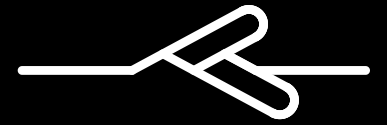

r=0.1335, dy=0.5391, Di=1.1831


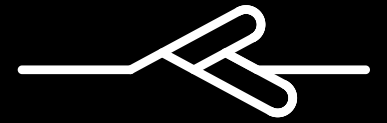

r=0.1387, dy=0.5391, Di=1.2606


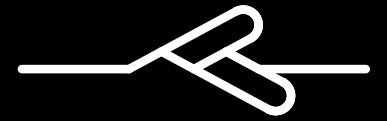

r=0.1439, dy=0.5391, Di=1.2613


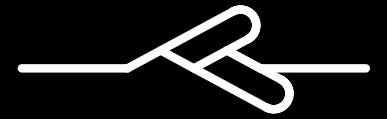

r=0.1491, dy=0.5391, Di=1.2369


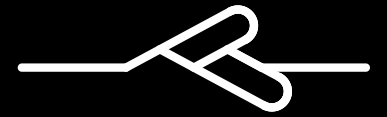

r=0.1543, dy=0.5391, Di=1.2317


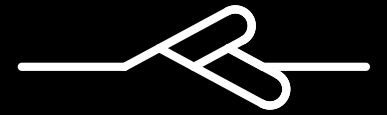

r=0.1596, dy=0.5391, Di=1.3036


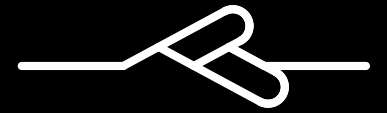

r=0.1648, dy=0.5391, Di=1.3381


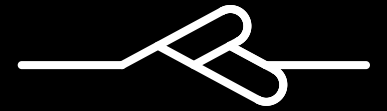

r=0.1700, dy=0.5391, Di=1.2754


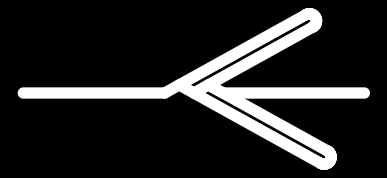

r=0.0500, dy=0.5543, Di=1.0934


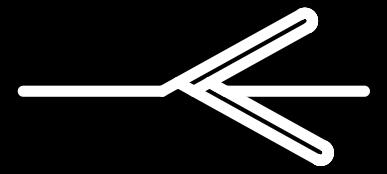

r=0.0552, dy=0.5543, Di=1.1006


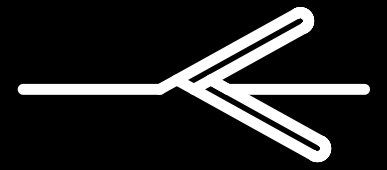

r=0.0604, dy=0.5543, Di=1.1248


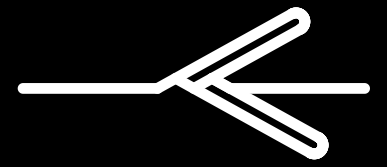

r=0.0657, dy=0.5543, Di=1.1035


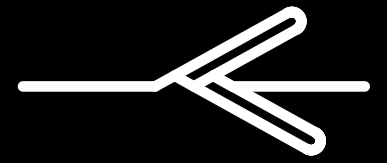

r=0.0709, dy=0.5543, Di=1.1177


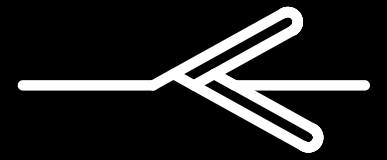

r=0.0761, dy=0.5543, Di=1.1295


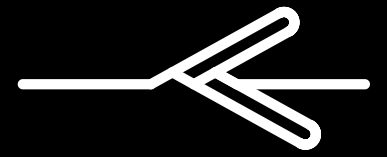

r=0.0813, dy=0.5543, Di=1.1459


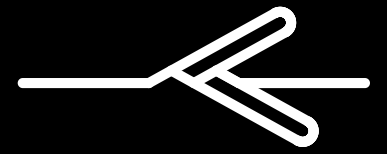

r=0.0865, dy=0.5543, Di=1.1531


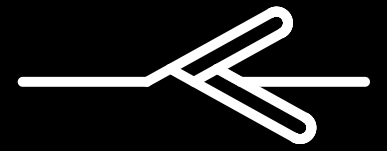

r=0.0917, dy=0.5543, Di=1.1849


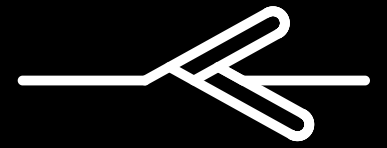

r=0.0970, dy=0.5543, Di=1.1704


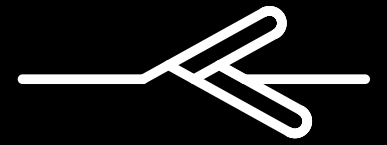

r=0.1022, dy=0.5543, Di=1.1723


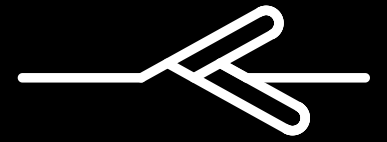

r=0.1074, dy=0.5543, Di=1.1940


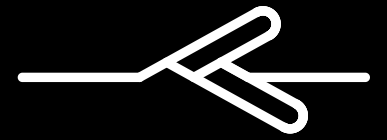

r=0.1126, dy=0.5543, Di=1.2238


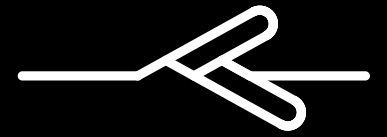

r=0.1178, dy=0.5543, Di=1.1641


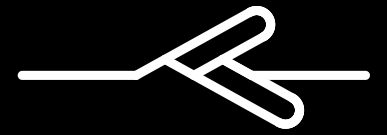

r=0.1230, dy=0.5543, Di=1.2197


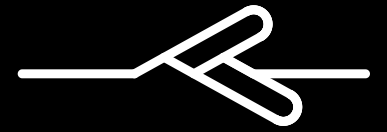

r=0.1283, dy=0.5543, Di=1.2173


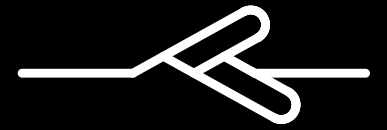

r=0.1335, dy=0.5543, Di=1.2404


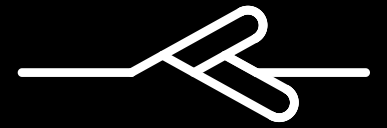

r=0.1387, dy=0.5543, Di=1.2440


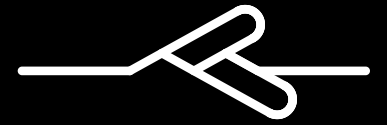

r=0.1439, dy=0.5543, Di=1.2584


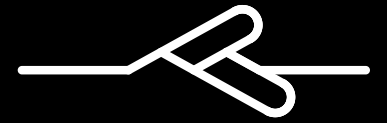

r=0.1491, dy=0.5543, Di=1.2743


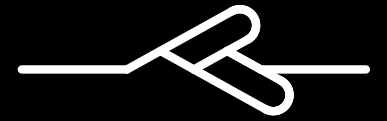

r=0.1543, dy=0.5543, Di=1.2308


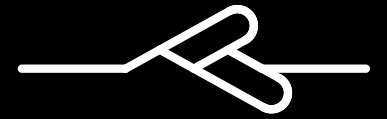

r=0.1596, dy=0.5543, Di=1.2379


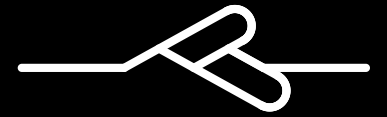

r=0.1648, dy=0.5543, Di=1.3107


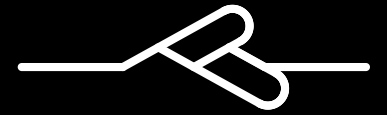

r=0.1700, dy=0.5543, Di=1.2556


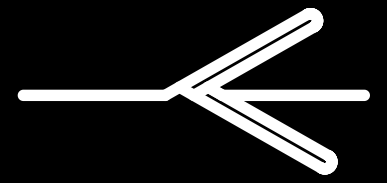

r=0.0500, dy=0.5696, Di=1.0996


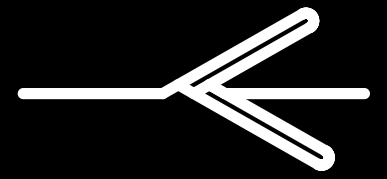

r=0.0552, dy=0.5696, Di=1.0918


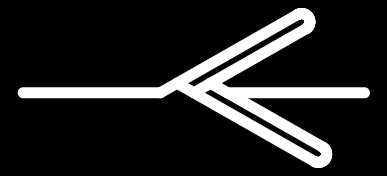

r=0.0604, dy=0.5696, Di=1.1086


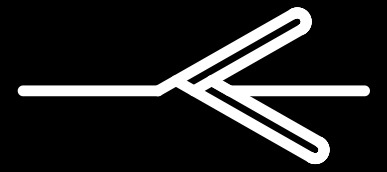

r=0.0657, dy=0.5696, Di=1.1159


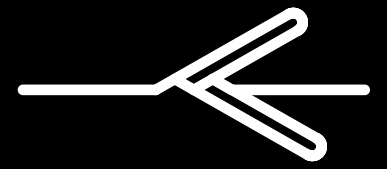

r=0.0709, dy=0.5696, Di=1.1355


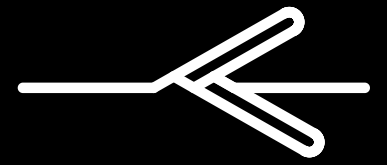

r=0.0761, dy=0.5696, Di=1.1454


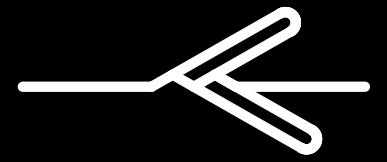

r=0.0813, dy=0.5696, Di=1.1808


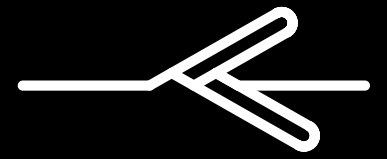

r=0.0865, dy=0.5696, Di=1.1392


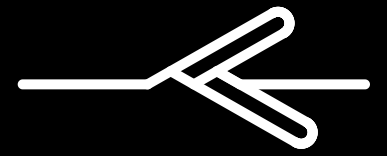

r=0.0917, dy=0.5696, Di=1.1522


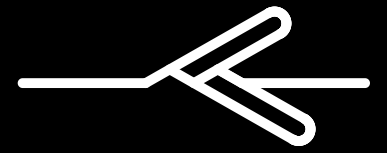

r=0.0970, dy=0.5696, Di=1.1702


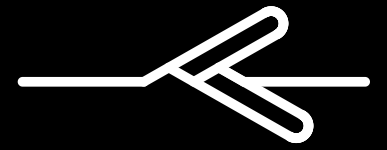

r=0.1022, dy=0.5696, Di=1.1392


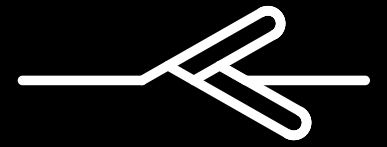

r=0.1074, dy=0.5696, Di=1.1767


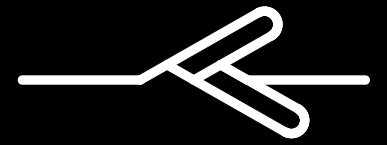

r=0.1126, dy=0.5696, Di=1.1812


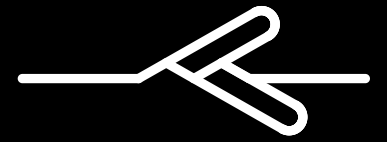

r=0.1178, dy=0.5696, Di=1.2194


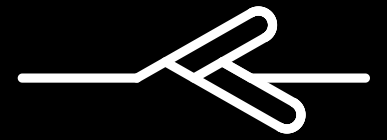

r=0.1230, dy=0.5696, Di=1.1610


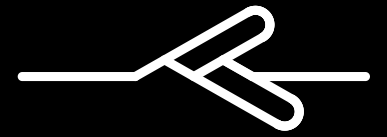

r=0.1283, dy=0.5696, Di=1.2037


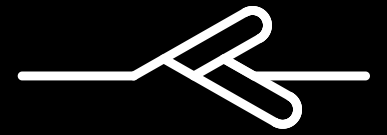

r=0.1335, dy=0.5696, Di=1.2151


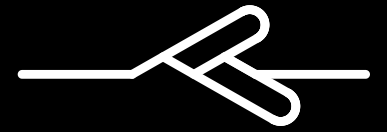

r=0.1387, dy=0.5696, Di=1.1786


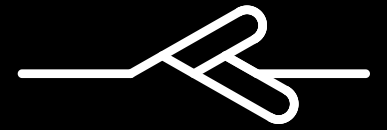

r=0.1439, dy=0.5696, Di=1.2438


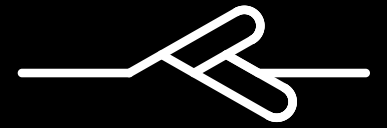

r=0.1491, dy=0.5696, Di=1.2606


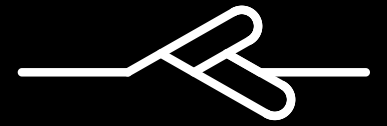

r=0.1543, dy=0.5696, Di=1.2193


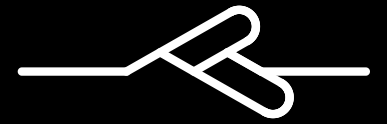

r=0.1596, dy=0.5696, Di=1.2304


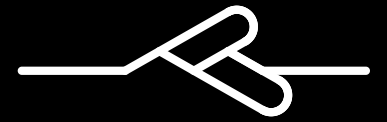

r=0.1648, dy=0.5696, Di=1.2908


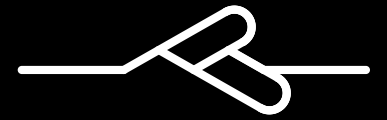

r=0.1700, dy=0.5696, Di=1.3208


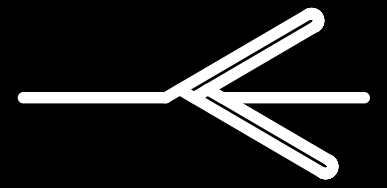

r=0.0500, dy=0.5848, Di=1.0855


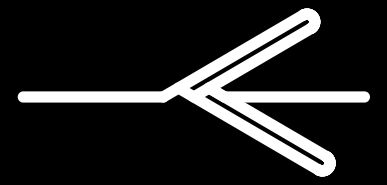

r=0.0552, dy=0.5848, Di=1.0953


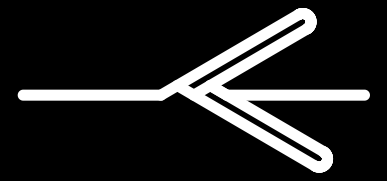

r=0.0604, dy=0.5848, Di=1.1016


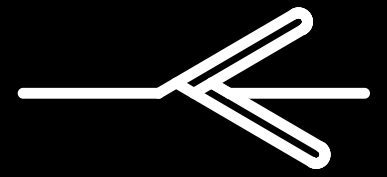

r=0.0657, dy=0.5848, Di=1.1126


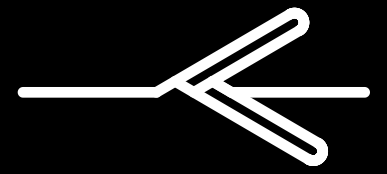

r=0.0709, dy=0.5848, Di=1.1126


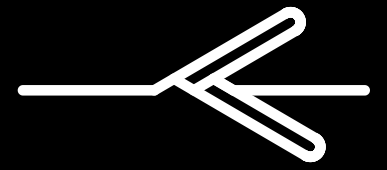

r=0.0761, dy=0.5848, Di=1.1157


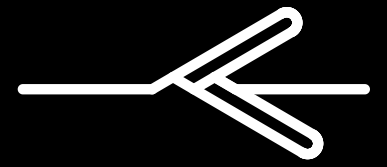

r=0.0813, dy=0.5848, Di=1.1253


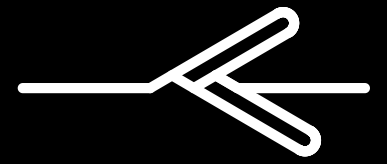

r=0.0865, dy=0.5848, Di=1.1471


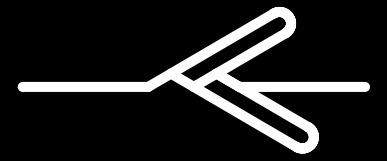

r=0.0917, dy=0.5848, Di=1.1822


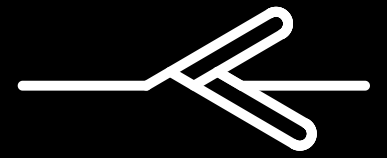

r=0.0970, dy=0.5848, Di=1.1452


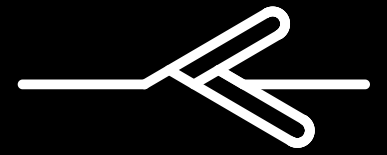

r=0.1022, dy=0.5848, Di=1.1815


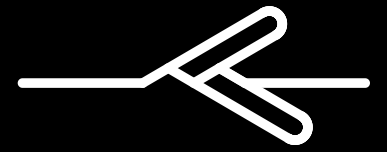

r=0.1074, dy=0.5848, Di=1.1727


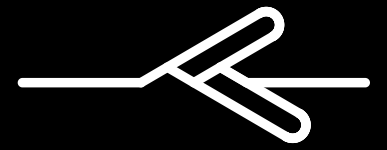

r=0.1126, dy=0.5848, Di=1.1889


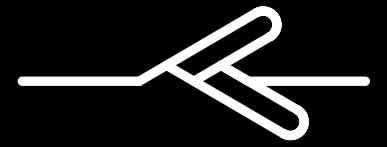

r=0.1178, dy=0.5848, Di=1.2123


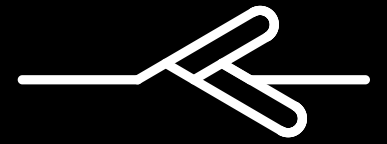

r=0.1230, dy=0.5848, Di=1.1676


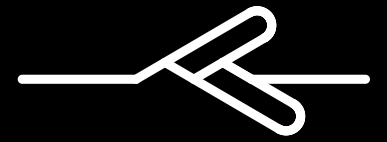

r=0.1283, dy=0.5848, Di=1.2086


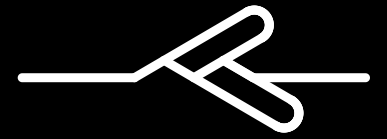

r=0.1335, dy=0.5848, Di=1.2078


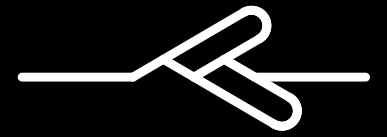

r=0.1387, dy=0.5848, Di=1.2405


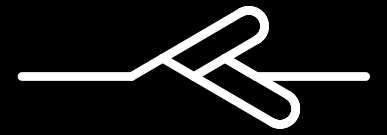

r=0.1439, dy=0.5848, Di=1.2410


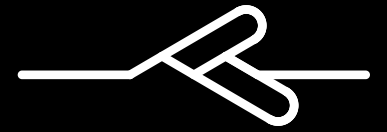

r=0.1491, dy=0.5848, Di=1.2357


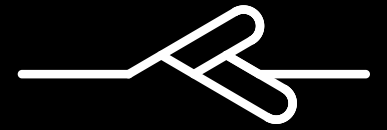

r=0.1543, dy=0.5848, Di=1.2786


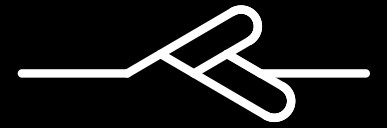

r=0.1596, dy=0.5848, Di=1.2114


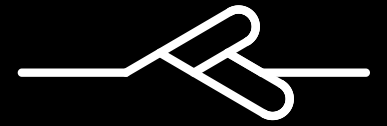

r=0.1648, dy=0.5848, Di=1.2410


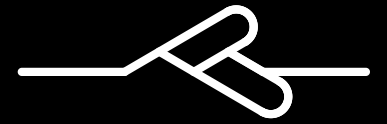

r=0.1700, dy=0.5848, Di=1.2984


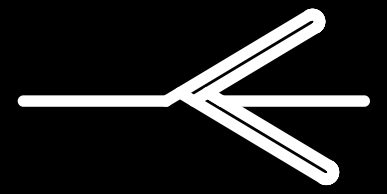

r=0.0500, dy=0.6000, Di=1.0665


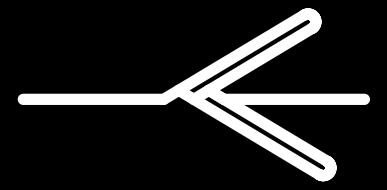

r=0.0552, dy=0.6000, Di=1.1206


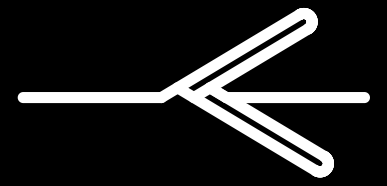

r=0.0604, dy=0.6000, Di=1.1048


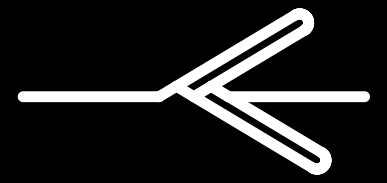

r=0.0657, dy=0.6000, Di=1.1274


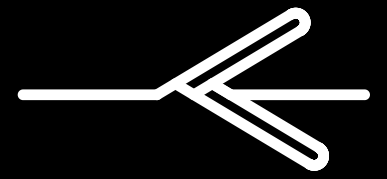

r=0.0709, dy=0.6000, Di=1.1260


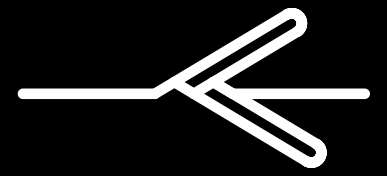

r=0.0761, dy=0.6000, Di=1.1406


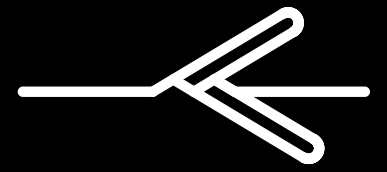

r=0.0813, dy=0.6000, Di=1.1498


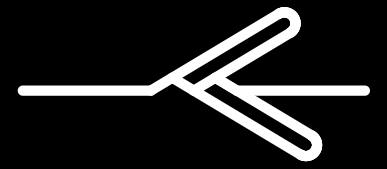

r=0.0865, dy=0.6000, Di=1.1327


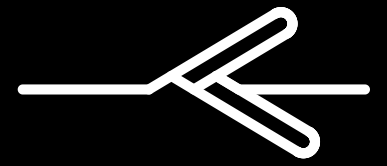

r=0.0917, dy=0.6000, Di=1.1500


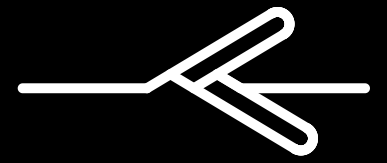

r=0.0970, dy=0.6000, Di=1.1487


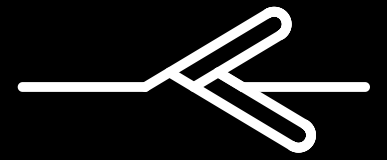

r=0.1022, dy=0.6000, Di=1.1708


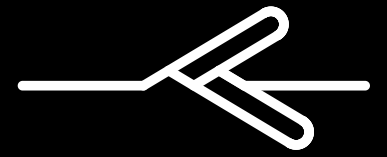

r=0.1074, dy=0.6000, Di=1.1751


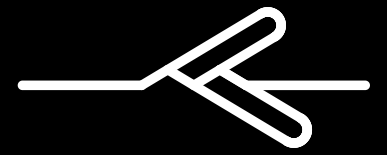

r=0.1126, dy=0.6000, Di=1.1889


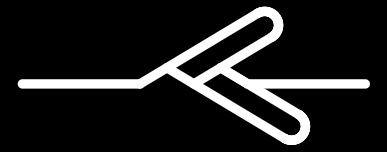

r=0.1178, dy=0.6000, Di=1.1839


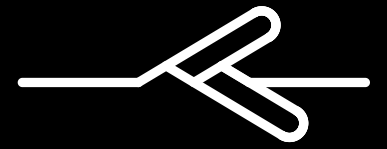

r=0.1230, dy=0.6000, Di=1.2222


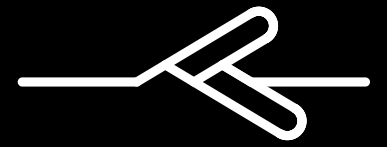

r=0.1283, dy=0.6000, Di=1.1880


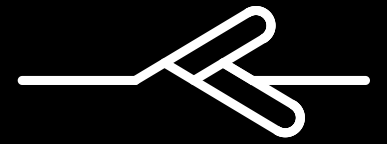

r=0.1335, dy=0.6000, Di=1.2261


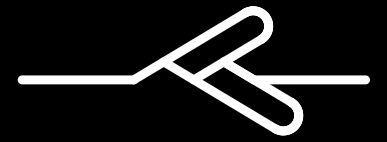

r=0.1387, dy=0.6000, Di=1.2258


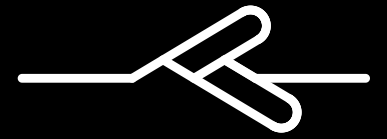

r=0.1439, dy=0.6000, Di=1.2342


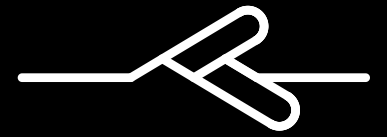

r=0.1491, dy=0.6000, Di=1.2411


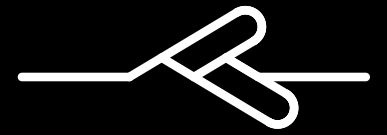

r=0.1543, dy=0.6000, Di=1.2538


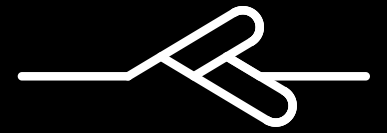

r=0.1596, dy=0.6000, Di=1.2047


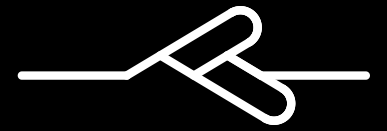

r=0.1648, dy=0.6000, Di=1.2194


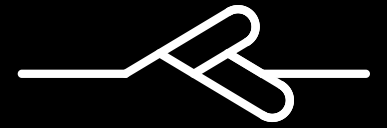

r=0.1700, dy=0.6000, Di=1.2906


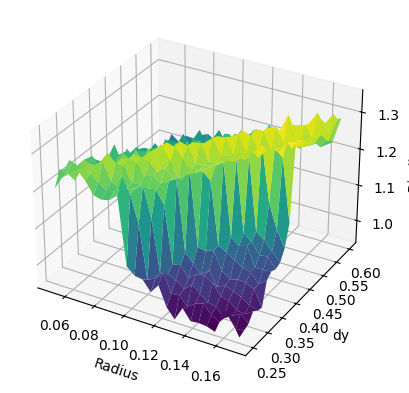

In [5]:
# -------------------------
# Parameter ranges
# -------------------------
r0, r1 = 0.05, 0.17
dy0, dy1 = 0.25, 0.6
N = 24

radius = np.linspace(r0, r1, N)
dy = np.linspace(dy0, dy1, N)

R, DY = np.meshgrid(radius, dy)
D = np.zeros((N, N))

csv_path = Path("results/diodicity_surface.csv")

if csv_path.exists():
    csv_path.unlink()

write_header = True

# -------------------------
# Parameter sweep
# -------------------------
for i, y in enumerate(dy):
    for j, r in enumerate(radius):

        generate_valve(0.04, 2, y, r, 1)

        sim_params = {
            "png_path": "data/valve.png",
            "visualization_by": "pressure_field",
            "la": 1.03,
            "resolution_factor": 1,
            "input_vel": 0.020,
        }

        sim_rev = Simulation(flip_x=False, **sim_params)
        sim_for = Simulation(flip_x=True, **sim_params)

        sim_for.run()
        sim_rev.run()

        reverse_res = sim_rev.flow_resistance()
        forward_res = sim_for.flow_resistance()

        diodicity = reverse_res / forward_res
        D[i, j] = diodicity

        print(f"r={r:.4f}, dy={y:.4f}, Di={diodicity:.4f}")

        # -------------------------
        # Immediate CSV write
        # -------------------------
        df = pd.DataFrame(
            {
                "radius": [r],
                "dy": [y],
                "diodicity": [diodicity],
            }
        )

        df.to_csv(
            csv_path,
            mode="a",
            header=write_header,
            index=False,
        )
        write_header = False

# -------------------------
# 3D Plot
# -------------------------

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(R, DY, D, cmap="viridis")

ax.set_xlabel("Radius")
ax.set_ylabel("dy")
ax.set_zlabel("Diodicity")

plt.show()

## Experiment 6

Finding minimum using scipy.optimize.minimize

In [ ]:
from scipy.optimize import minimize
it = 0

def objective(x, it=0):
    it += 1
    w, r, dy = x

    if w <= 0 or r <= 0 or dy <= 0:
        return 1e6

    generate_valve(w, 2, dy, r, 1)

    params = {
        "png_path": "data/valve.png",
        "visualization_by": "pressure_field",
        "la": 1.03,
        "resolution_factor": 1,
        "input_vel": 0.020,
        "Tf": 4000
    }

    sim_f = Simulation(flip_x=True, **params)
    sim_r = Simulation(flip_x=False, **params)

    sim_f.run()
    sim_r.run()

    rf = sim_f.flow_resistance()
    rr = sim_r.flow_resistance()

    print(it)
    print(x)
    print(-rr / rf if rf > 0 else 1e6)

    return -rr / rf if rf > 0 else 1e6


x0 = [0.04, 0.13, 0.4]
bounds = [(0.03, 0.1), (0.05, 0.17), (0.25, 0.6)]

res = minimize(objective, x0, method="Nelder-Mead", bounds=bounds, options={"maxiter": 100})

print("x* =", res.x)
print("diodicity =", -res.fun)